# DATA2901 Assignment Data Workflow - ADV02 Group 10 

## Python/SQL Setup

In [3]:
from sqlalchemy import create_engine, inspect
from sqlalchemy import text 
import psycopg2
import psycopg2.extras
import json
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import geoalchemy2
from shapely import wkt
from shapely.geometry import Point, Polygon, MultiPolygon
import json
import re
import time as t
import random 
import seaborn as sns
import matplotlib.pyplot as plt

# Helper methods for connecting to and querying postgres server
def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['user']
        try:
            db = create_engine('postgresql+psycopg2://'+db_user+':'+db_pw+'@'+host+'/'+default_db, echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        
        # Making schema selection easier 
        if db_schema != "public" and db != None and conn != None:
            try:
                # IF THIS DOESNT WORK FOR CHRIS OR LUKA, REMOVE THE TEXT() WRAPPER
                conn.execute(text("set search_path to " + db_schema))
                print("Search path set to " + db_schema)
            except Exception as e:
                print("Unable to set search path to "+ db_schema)
                print(e)
                pgdisconnect(db, conn)
                
        return db,conn

def query(conn, sqlcmd, args=None, df=True):
    # conn = database connection object, sqlcmd = string holding command
    result = pd.DataFrame() if df else None
    sqlcmd = text(sqlcmd)
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(sqlcmd, args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

''' in case the text() causes issues down the line
def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(sqlcmd, args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result
'''

# Creates WKT elements and if encountered, converts polygons to multipolygons
def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return geoalchemy2.WKTElement(geom.wkt, srid)

# Disconnects from server, able to commit changes here
def pgdisconnect(db, conn, commit=False):
    try:
        if commit:
            conn.commit()
            print("Changes committed.")
        conn.close()
        db.dispose()
        print("Disconnected from database.")
        return True
    except Exception as e:
        print("Unable to disconnect from the database.")
        print(e)
        return False

# Utilises disconnect + reconnect methods, best for unique servers like Yash's where you must commit or no change is saved
def pgreconnect(credentials, old_db, old_conn, db_schema="public", commit=False):
    if pgdisconnect(old_db, old_conn, commit):
        return pgconnect(credentials, db_schema)
    else:
        print("No new connection made.")
        return None, None

In [4]:
# Connecting to database
credentials = "Credentials.json"
db, conn = pgconnect(credentials, 'sa2')

Connected successfully.
Search path set to sa2


In [5]:
# Creating new schema to store all tables created
sql = """
CREATE SCHEMA IF NOT EXISTS sa2;
SET search_path TO sa2;
"""

conn.execute(text(sql))

In [4]:
# Adding PostGIS to sa2 schema
sql = """
CREATE EXTENSION IF NOT EXISTS postgis;

UPDATE pg_extension
SET extrelocatable = TRUE
WHERE extname = 'postgis';

ALTER EXTENSION postgis
SET SCHEMA sa2;
"""

conn.execute(text(sql))
query(conn, "SELECT PostGIS_version()") 

,postgis_version
0,3.3 USE_GEOS=1 USE_PROJ=1 USE_STATS=1


In [5]:
#db, conn = pgreconnect(credentials, db, conn, 'sa2', True)
#query(conn, "SET SEARCH_PATH TO sa2")

## Task 1: Cleaning & Importing Datasets

### SA2 Regions dataset
The regions dataset provides basic information on the level 2 statistical areas (SA2) that divide Australia into communities of approximately 10000 people.
Originating from the ABS, the table includes the name of each SA2 region as well as its geographical location and area, allowing it to act as the central table for all other tables to perform joins with it.

The regions dataset is provided as a shapefile, and so can be loaded directly into geopandas:

In [6]:
# Loading and inspecting the dataset
path = "SA2_2021_AUST_SHP_GDA2020/SA2_2021_AUST_GDA2020.shp"
regions = gpd.read_file(path)
print(regions.shape)
print(regions.columns)
print(regions.dtypes)
regions.head()

(2473, 17)
Index(['SA2_CODE21', 'SA2_NAME21', 'CHG_FLAG21', 'CHG_LBL21', 'SA3_CODE21',
       'SA3_NAME21', 'SA4_CODE21', 'SA4_NAME21', 'GCC_CODE21', 'GCC_NAME21',
       'STE_CODE21', 'STE_NAME21', 'AUS_CODE21', 'AUS_NAME21', 'AREASQKM21',
       'LOCI_URI21', 'geometry'],
      dtype='object')
SA2_CODE21      object
SA2_NAME21      object
CHG_FLAG21      object
CHG_LBL21       object
SA3_CODE21      object
SA3_NAME21      object
SA4_CODE21      object
SA4_NAME21      object
GCC_CODE21      object
GCC_NAME21      object
STE_CODE21      object
STE_NAME21      object
AUS_CODE21      object
AUS_NAME21      object
AREASQKM21     float64
LOCI_URI21      object
geometry      geometry
dtype: object


,SA2_CODE21,SA2_NAME21,CHG_FLAG21,CHG_LBL21,SA3_CODE21,SA3_NAME21,SA4_CODE21,SA4_NAME21,GCC_CODE21,GCC_NAME21,STE_CODE21,STE_NAME21,AUS_CODE21,AUS_NAME21,AREASQKM21,LOCI_URI21,geometry
0,101021007,Braidwood,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,3418.3525,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.58424 -35.44426, 149.58444 -35.4..."
1,101021008,Karabar,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,6.9825,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.21899 -35.36738, 149.21800 -35.3..."
2,101021009,Queanbeyan,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,4.7620,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.21326 -35.34325, 149.21619 -35.3..."
3,101021010,Queanbeyan - East,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,13.0032,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.24034 -35.34781, 149.24024 -35.3..."
4,101021012,Queanbeyan West - Jerrabomberra,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,13.6748,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.19572 -35.36126, 149.19970 -35.3..."


For this analysis, we are only interested in the SA2 regions within greater Sydney. We will filter for only these particular regions here:

In [7]:
# Filter for only the SA2 regions in greater Sydney
regions = regions[regions["GCC_CODE21"] == "1GSYD"]

We will also clean the table, removing all other unnecessary columns:

In [8]:
# Removing unnecessary columns
to_remove = ["CHG_FLAG21", "CHG_LBL21", "GCC_CODE21", "GCC_NAME21", "STE_CODE21", "STE_NAME21", "AUS_CODE21", "AUS_NAME21", "LOCI_URI21"]
regions.drop(to_remove, axis=1, inplace=True)

Given that some regions are provided as a POLYGON while others are a MULTIPOLYGON, we will need to convert them all to the same datatype:

In [9]:
# Converting all POLYGON types to MULTIPOLYGON
regions["geom"] = regions["geometry"].apply(lambda x: create_wkt_element(geom=x,srid=7844))
regions.drop(columns="geometry", inplace=True)

In [60]:
# Renaming columns
regions.rename({
    "SA2_CODE21":"sa2_code",
    "SA2_NAME21":"sa2_name",
    "SA3_CODE21":"sa3_code",
    "SA3_NAME21":"sa3_name",
    "SA4_CODE21":"sa4_code",
    "SA4_NAME21":"sa4_name",
    "AREASQKM21":"area_sqkm",
    "geom":"geometry"
}, axis=1, inplace=True)

# Correcting datatypes
regions = regions.astype({"sa2_code":"int64", "sa3_code":"int64", "sa4_code":"int64"})

In [61]:
# Inspecting the dataset after modifcation
regions.head()

,sa2_code,sa2_name,sa3_code,sa3_name,sa4_code,sa4_name,area_sqkm,geometry
28,102011028,Avoca Beach - Copacabana,10201,Gosford,102,Central Coast,6.4376,MULTIPOLYGON (((151.413733024921 -33.465580583...
29,102011029,Box Head - MacMasters Beach,10201,Gosford,102,Central Coast,32.0802,MULTIPOLYGON (((151.37484081570685 -33.5005199...
30,102011030,Calga - Kulnura,10201,Gosford,102,Central Coast,767.9512,MULTIPOLYGON (((151.20449037540152 -33.5328022...
31,102011031,Erina - Green Point,10201,Gosford,102,Central Coast,33.7934,MULTIPOLYGON (((151.37193611462118 -33.4369790...
32,102011032,Gosford - Springfield,10201,Gosford,102,Central Coast,16.9123,MULTIPOLYGON (((151.32348639265098 -33.4277852...


Finally, we will add the DataFrame to the database:

In [62]:
# Adding to postgresql database
sql = """
DROP TABLE IF EXISTS regions CASCADE;
CREATE TABLE regions (
    sa2_code INTEGER PRIMARY KEY,
    sa2_name VARCHAR(100) UNIQUE NOT NULL,
    sa3_code INTEGER NOT NULL,
    sa3_name VARCHAR(100) NOT NULL,
    sa4_code INTEGER NOT NULL,
    sa4_name VARCHAR(100) NOT NULL,
    area_sqkm NUMERIC NOT NULL,
    geometry GEOMETRY(MULTIPOLYGON, 7844) NOT NULL
);"""
conn.execute(text(sql));

regions.to_sql(name="regions", con=conn, schema="sa2", if_exists="append", index=False,
              dtype={'geometry': geoalchemy2.Geometry('MULTIPOLYGON', 7844)})

query(conn, "SELECT * FROM regions LIMIT 5;")

,sa2_code,sa2_name,sa3_code,sa3_name,sa4_code,sa4_name,area_sqkm,geometry
0,102011028,Avoca Beach - Copacabana,10201,Gosford,102,Central Coast,6.4376,0106000020A41E0000010000000103000000010000005E...
1,102011029,Box Head - MacMasters Beach,10201,Gosford,102,Central Coast,32.0802,0106000020A41E00000100000001030000000100000010...
2,102011030,Calga - Kulnura,10201,Gosford,102,Central Coast,767.9512,0106000020A41E00000200000001030000000100000085...
3,102011031,Erina - Green Point,10201,Gosford,102,Central Coast,33.7934,0106000020A41E00000100000001030000000100000041...
4,102011032,Gosford - Springfield,10201,Gosford,102,Central Coast,16.9123,0106000020A41E0000010000000103000000010000007E...


### Business dataset
The business dataset comes from the ABS once again and provides us with the counts of each type of business (including health and retail businesses as required in our analysis), and further partitioned by their annual turnover. For the analysis section, this table will help us in calculating both the $z_{retail}$ and $z_{health}$ scores.

It should also be noted that this datset is provided to us in long form, so we will need to write slightly different code to correctly merge the table with the regions dataset in the future.

The dataset is provided as a csv file, so we can read it into pandas:

In [63]:
# Loading and inspecting the dataset
business = pd.read_csv("Businesses.csv")
print(business.shape)
print(business.columns)
print(business.dtypes)

(12217, 11)
Index(['industry_code', 'industry_name', 'sa2_code', 'sa2_name',
       '0_to_50k_businesses', '50k_to_200k_businesses',
       '200k_to_2m_businesses', '2m_to_5m_businesses', '5m_to_10m_businesses',
       '10m_or_more_businesses', 'total_businesses'],
      dtype='object')
industry_code             object
industry_name             object
sa2_code                   int64
sa2_name                  object
0_to_50k_businesses        int64
50k_to_200k_businesses     int64
200k_to_2m_businesses      int64
2m_to_5m_businesses        int64
5m_to_10m_businesses       int64
10m_or_more_businesses     int64
total_businesses           int64
dtype: object


Each of the different industries covered in the dataset are as follows:

In [14]:
# View of the particular industries accounted for in each sa2 region
business[["industry_code", "industry_name"]].drop_duplicates()

,industry_code,industry_name
0,A,"Agriculture, Forestry and Fishing"
643,B,Mining
1286,C,Manufacturing
1929,D,"Electricity, Gas, Water and Waste Services"
2572,E,Construction
3215,F,Wholesale Trade
3858,G,Retail Trade
4501,H,Accommodation and Food Services
5144,I,"Transport, Postal and Warehousing"
5787,J,Information Media and Telecommunications


To be able to correctly join this table with the regions dataset and improve the accuracy of our analysis, we will need to remove the SA2 code for "currently unknown" (199999499) from the table:

In [15]:
business = business[business["sa2_code"] != 199999499]

In addition, to reduce the amount of storage required to store the table we will also filter for only the sa2_codes contained in the regions dataset (that is, the SA2 regions in greater Sydney):

In [16]:
business = business.loc[business["sa2_code"].isin(regions["sa2_code"])]

To ensure the quality of our data, we should also check that the count of the businesses in each size category adds to the total_businesses column:

In [17]:
# Checking if sum of businesses equals total businesses column
accounted_businesses = sum(business.loc[:,"0_to_50k_businesses":"5m_to_10m_businesses":1].sum(axis=1) == business["total_businesses"])
prop_correct_business_sum = accounted_businesses/business.shape[0]
round(prop_correct_business_sum, 2)

0.33

As we can see, these total_businesses values will need to be corrected to follow the sum of the number of businesses in each category:

In [18]:
business["total_businesses"] = business.loc[:,"0_to_50k_businesses":"5m_to_10m_businesses":1].sum(axis=1)

Finally, we need to export this DataFrame from pandas into the postgresql database:

In [19]:
# Selecting required columns
business = business[["sa2_code", "industry_code", "industry_name", "total_businesses"]]

# Adding to postgresql database
sql = """
DROP TABLE IF EXISTS business;
CREATE TABLE business (
    sa2_code INTEGER NOT NULL REFERENCES regions (sa2_code),
    industry_code CHAR(1) NOT NULL,
    industry_name VARCHAR(50) NOT NULL,
    total_businesses INTEGER NOT NULL,
    
    PRIMARY KEY (sa2_code, industry_code)
);"""
conn.execute(text(sql));

business.to_sql("business", conn, schema="sa2", if_exists="append", index=False)

query(conn, "SELECT * FROM business LIMIT 5;")

,sa2_code,industry_code,industry_name,total_businesses
0,102011028,A,"Agriculture, Forestry and Fishing",6
1,102011029,A,"Agriculture, Forestry and Fishing",17
2,102011030,A,"Agriculture, Forestry and Fishing",214
3,102011031,A,"Agriculture, Forestry and Fishing",27
4,102011032,A,"Agriculture, Forestry and Fishing",19


It is important to note for the future that the business dataset provides an explicit sa2_code column, allowing us to join this table with the sa2_code column in the regions dataset for the analysis.

### Stops dataset
The stops dataset comes from Transport for NSW and provides information on all of the public transport stops located in New South Wales (including bus stops, train stations and ferry wharfs), and is publicly available online.
For tasks 2 and 3, this table will directly help us in calculating the $z_{stops}$ score, however the wheelchair_boarding field may also become useful during further analysis.

Since the stops file provided is in a GTFS format, we will first load it in as a csv file with pandas, then convert it into a GeoDataFrame with geopandas.

A reference to the GTFS conventions (specifically the stops.txt file) can be found below:
https://developers.google.com/transit/gtfs/reference#stopstxt

In [20]:
## Loading and inspecting DataFrame
stops_df = pd.read_csv("Stops.txt")
print(stops_df.shape)
print(stops_df.columns)

# Filtering for only the stops
stops_df = stops_df[stops_df["location_type"].isna() & stops_df["stop_code"].notna()]

# Correcting datatypes
stops_df[["wheelchair_boarding"]] = stops_df[["wheelchair_boarding"]].replace({0:np.nan, 1:True, 2:False})
stops_df = stops_df.astype({"stop_code":"int64", "wheelchair_boarding":bool})

print(stops_df.dtypes)

(114718, 9)
Index(['stop_id', 'stop_code', 'stop_name', 'stop_lat', 'stop_lon',
       'location_type', 'parent_station', 'wheelchair_boarding',
       'platform_code'],
      dtype='object')
stop_id                 object
stop_code                int64
stop_name               object
stop_lat               float64
stop_lon               float64
location_type          float64
parent_station          object
wheelchair_boarding       bool
platform_code           object
dtype: object


Now we need to convert the DataFrame into a GeoDataFrame with geopandas:

In [21]:
# Converting into GeoDataFrame
stops_gdf = gpd.GeoDataFrame(stops_df, geometry=gpd.points_from_xy(stops_df.stop_lon, stops_df.stop_lat)).set_crs(epsg=4326)


# Removing unnecessary columns
stops_gdf.drop(["stop_id", "stop_lon", "parent_station", "stop_lat", "location_type", "platform_code"], axis=1, inplace=True)
stops_gdf.head()

# Conducting WKT conversion
stops_gdf['geometry'] = stops_gdf['geometry'].apply(lambda x: geoalchemy2.WKTElement(x.wkt, 4326))

stops_gdf.head()

/home/chris/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1442: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


,stop_code,stop_name,wheelchair_boarding,geometry
0,200039,"Central Station, Eddy Av, Stand A",True,POINT (151.20666465471 -33.8822064874687)
1,200054,"Central Station, Eddy Av, Stand D",True,POINT (151.20699145565 -33.8820421431408)
4,201646,"Redfern Station, Gibbons St, Stand B",True,POINT (151.198881722942 -33.8933293130144)
5,204230,"St Peters Station, King St",True,POINT (151.181117167927 -33.9063142029908)
6,204311,King St Opp St Peters Station,True,POINT (151.181371008764 -33.9064227004899)


Finally, we need to export this GeoDataFrame from geopandas into the postgresql database:

In [22]:
# Adding to postgresql database
sql = """
DROP TABLE IF EXISTS stops;
CREATE TABLE stops (
    stop_code INTEGER PRIMARY KEY,
    stop_name VARCHAR(100) NOT NULL,
    wheelchair_boarding BOOLEAN,
    geometry GEOMETRY(POINT, 4326) NOT NULL
);"""
conn.execute(text(sql));

stops_gdf.to_sql("stops", conn, schema="sa2", if_exists="append", index=False, dtype={'geometry': geoalchemy2.Geometry('POINT', 4326)})

query(conn, "SELECT * FROM stops LIMIT 5;")

,stop_code,stop_name,wheelchair_boarding,geometry
0,200039,"Central Station, Eddy Av, Stand A",True,0101000020E6100000FFA631FF9CE66240A1FF6524ECF0...
1,200054,"Central Station, Eddy Av, Stand D",True,0101000020E61000002F928BAC9FE66240E33DC7C1E6F0...
2,201646,"Redfern Station, Gibbons St, Stand B",True,0101000020E6100000DBF9333D5DE662403DFA6B9D58F2...
3,204230,"St Peters Station, King St",True,0101000020E6100000B31F3BB6CBE5624076DF921A02F4...
4,204311,King St Opp St Peters Station,True,0101000020E6100000AFE292CACDE56240627AB7A805F4...


As this dataset provides the geographic location of each stop with only 1 point (a longitude and latitude value), we will need to check each point and see what SA2 region they are contained within when joining it with the regions dataset.

### Polls dataset
The polls dataset, retrieved from the Australian Electoral Commission, provides a list of all of the polling places used during the 2019 federal election, including their geographical location and which electorate they fall under.
During tasks 2 and 3, this dataset will be used in calculating the $z_{polls}$ score.

Since for the purposes of this assignment we need to assign each polling place a location, we will only use the entries where this column is not NULL.

In [23]:
## Loading and inspecting DataFrame
polls_df = pd.read_csv("PollingPlaces2019.csv")
print(polls_df.shape)
print(polls_df.columns)
print(polls_df.dtypes)

# Updating datatype of the_geom
polls_df = polls_df[polls_df['the_geom'].notna()]
polls_df["the_geom"] = polls_df["the_geom"].apply(wkt.loads)

(2930, 17)
Index(['FID', 'state', 'division_id', 'division_name', 'polling_place_id',
       'polling_place_type_id', 'polling_place_name', 'premises_name',
       'premises_address_1', 'premises_address_2', 'premises_address_3',
       'premises_suburb', 'premises_state_abbreviation', 'premises_post_code',
       'latitude', 'longitude', 'the_geom'],
      dtype='object')
FID                             object
state                           object
division_id                      int64
division_name                   object
polling_place_id                 int64
polling_place_type_id            int64
polling_place_name              object
premises_name                   object
premises_address_1              object
premises_address_2              object
premises_address_3              object
premises_suburb                 object
premises_state_abbreviation     object
premises_post_code             float64
latitude                       float64
longitude                      float64


Now we need to convert the DataFrame into a GeoDataFrame with geopandas.

It is important to note that although the polls dataset already has a POINT object implemented into the table, the longitude and latitude coordinates are labelled inconsistently with the other tables, and thus will need to be switched around:

In [24]:
# Loading into GeoDataFrame
polls_gdf = gpd.GeoDataFrame(polls_df, geometry=gpd.points_from_xy(polls_df.longitude, polls_df.latitude)).set_crs(epsg=4283)

# Removing unnecessary columns
polls_gdf.drop(["longitude", "latitude", "the_geom", "FID", "state", "polling_place_name", "polling_place_type_id", "premises_name", "premises_address_1", "premises_address_2", "premises_address_3", "premises_suburb", "premises_state_abbreviation", "premises_post_code"], axis=1, inplace=True)

# Conducting WKT conversion
polls_gdf['geometry'] = polls_gdf['geometry'].apply(lambda x: geoalchemy2.WKTElement(x.wkt, 4283))

polls_gdf.head()

/home/chris/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1442: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


,division_id,division_name,polling_place_id,geometry
13,103,Banks,58,POINT (151.081 -33.9847)
15,111,Chifley,392,POINT (150.817 -33.7475)
16,103,Banks,31,POINT (151.1148974 -33.9767897)
17,103,Banks,67,POINT (151.111 -33.9756)
18,103,Banks,56500,POINT (151.075 -33.9413)


Finally, we need to export this GeoDataFrame from geopandas into the postgresql database:

In [25]:
# Adding to postgresql database
sql = """
DROP TABLE IF EXISTS polls;
CREATE TABLE polls (
    polling_place_id INTEGER PRIMARY KEY,
    division_id INTEGER NOT NULL,
    division_name VARCHAR(50) NOT NULL,
    geometry GEOMETRY(POINT, 4283) NOT NULL
);"""

conn.execute(text(sql));

polls_gdf.to_sql("polls", conn, schema="sa2", if_exists="append", index=False, dtype={'geometry': geoalchemy2.Geometry('POINT', 4283)})

query(conn, "SELECT * FROM polls LIMIT 5")

,polling_place_id,division_id,division_name,geometry
0,58,103,Banks,0101000020BB1000003BDF4F8D97E26240832F4CA60AFE...
1,392,111,Chifley,0101000020BB100000A01A2FDD24DA624048E17A14AEDF...
2,31,103,Banks,0101000020BB100000A7EC4F3DADE36240EA48E47107FD...
3,67,103,Banks,0101000020BB100000643BDF4F8DE3624022FDF675E0FC...
4,56500,103,Banks,0101000020BB1000006666666666E26240C6DCB5847CF8...


Just like before, this dataset provides the geographic location of each polling place with only 1 point (a longitude and latitude value), so we will need to check each point and see what SA2 region they are contained within when joining it with the regions dataset.

### School Catchments Dataset
The catchments dataset, sourced from the NSW Department of Education, provides the catchment region for each of the schools (primary and secondary school) found within New South Wales.
For the analysis section, the table will allow us to calculate the $z_{schools}$ score.

The three datasets are provided as individual shapefiles, so we will load each of into geopandas directly, then merge them together:

In [26]:
# Loading and inspecting the dataset
path = "Catchments/catchments_primary.shp"
primary = gpd.read_file(path)
print(primary.shape)
print(primary.columns)
print(primary.dtypes)
primary.head()

(1662, 19)
Index(['USE_ID', 'CATCH_TYPE', 'USE_DESC', 'ADD_DATE', 'KINDERGART', 'YEAR1',
       'YEAR2', 'YEAR3', 'YEAR4', 'YEAR5', 'YEAR6', 'YEAR7', 'YEAR8', 'YEAR9',
       'YEAR10', 'YEAR11', 'YEAR12', 'PRIORITY', 'geometry'],
      dtype='object')
USE_ID          object
CATCH_TYPE      object
USE_DESC        object
ADD_DATE        object
KINDERGART      object
YEAR1           object
YEAR2           object
YEAR3           object
YEAR4           object
YEAR5           object
YEAR6           object
YEAR7           object
YEAR8           object
YEAR9           object
YEAR10          object
YEAR11          object
YEAR12          object
PRIORITY        object
geometry      geometry
dtype: object


,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geometry
0,2838,PRIMARY,Parklea PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,NaN,"POLYGON ((150.93564 -33.71612, 150.93715 -33.7..."
1,2404,PRIMARY,Lindfield EPS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,NaN,"POLYGON ((151.18336 -33.74748, 151.18443 -33.7..."
2,4393,PRIMARY,Carlingford WPS,20220223,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,NaN,"POLYGON ((151.04518 -33.77303, 151.04526 -33.7..."
3,4615,PRIMARY,Caddies Ck PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,NaN,"POLYGON ((150.92567 -33.72960, 150.92602 -33.7..."
4,3918,PRIMARY,Killara PS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,NaN,"POLYGON ((151.15379 -33.75586, 151.15404 -33.7..."


In [27]:
# Loading and inspecting the dataset
path = "Catchments/catchments_secondary.shp"
secondary = gpd.read_file(path)
print(secondary.shape)
print(secondary.columns)
print(secondary.dtypes)
secondary.head()

(436, 19)
Index(['USE_ID', 'CATCH_TYPE', 'USE_DESC', 'ADD_DATE', 'KINDERGART', 'YEAR1',
       'YEAR2', 'YEAR3', 'YEAR4', 'YEAR5', 'YEAR6', 'YEAR7', 'YEAR8', 'YEAR9',
       'YEAR10', 'YEAR11', 'YEAR12', 'PRIORITY', 'geometry'],
      dtype='object')
USE_ID          object
CATCH_TYPE      object
USE_DESC        object
ADD_DATE        object
KINDERGART      object
YEAR1           object
YEAR2           object
YEAR3           object
YEAR4           object
YEAR5           object
YEAR6           object
YEAR7           object
YEAR8           object
YEAR9           object
YEAR10          object
YEAR11          object
YEAR12          object
PRIORITY        object
geometry      geometry
dtype: object


,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geometry
0,8503,HIGH_COED,Billabong HS,20200507,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,NaN,"POLYGON ((146.67182 -35.31444, 146.68930 -35.3..."
1,8266,HIGH_COED,James Fallon HS,20200507,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,NaN,"POLYGON ((147.08734 -35.86271, 147.10413 -35.8..."
2,8505,HIGH_COED,Murray HS,20200507,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,NaN,"POLYGON ((146.81448 -35.78341, 146.81250 -35.7..."
3,8458,HIGH_COED,Kingswood HS,20201016,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,NaN,"MULTIPOLYGON (((150.68600 -33.74031, 150.68631..."
4,8559,HIGH_COED,Jamison HS,20201016,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,NaN,"POLYGON ((150.69513 -33.75627, 150.68936 -33.7..."


In [28]:
# Loading and inspecting the dataset
path = "Catchments/catchments_future.shp"
future = gpd.read_file(path)
print(future.shape)
print(future.columns)
print(future.dtypes)
future.head()

(30, 18)
Index(['USE_ID', 'CATCH_TYPE', 'USE_DESC', 'ADD_DATE', 'KINDERGART', 'YEAR1',
       'YEAR2', 'YEAR3', 'YEAR4', 'YEAR5', 'YEAR6', 'YEAR7', 'YEAR8', 'YEAR9',
       'YEAR10', 'YEAR11', 'YEAR12', 'geometry'],
      dtype='object')
USE_ID          object
CATCH_TYPE      object
USE_DESC        object
ADD_DATE        object
KINDERGART       int64
YEAR1            int64
YEAR2            int64
YEAR3            int64
YEAR4            int64
YEAR5            int64
YEAR6            int64
YEAR7            int64
YEAR8            int64
YEAR9            int64
YEAR10           int64
YEAR11           int64
YEAR12           int64
geometry      geometry
dtype: object


,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,geometry
0,8416,HIGH_COED,Ku-ring-gai HS,20230114,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,"POLYGON ((151.19849 -33.53990, 151.19945 -33.5..."
1,8161,HIGH_BOYS,Randwick BHS,20200220,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,"POLYGON ((151.27152 -33.91402, 151.27152 -33.9..."
2,8539,HIGH_COED,SSC Blackwattle Bay,20220609,0,0,0,0,0,0,0,0,0,0,0,2024,2024,"POLYGON ((151.15292 -33.83939, 151.16144 -33.8..."
3,8400,HIGH_COED,St Ives HS,20230114,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,"POLYGON ((151.17794 -33.69820, 151.17859 -33.6..."
4,8555,HIGH_COED,Rose Bay SC,20200220,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,"POLYGON ((151.28072 -33.83287, 151.28095 -33.8..."


We will now merge all of the catchment tables together, keeping the version specified within the future dataset if there has been a recent change to the school catchment zone, as using it will improve the longevity and usefulness of our findings.

In [29]:
#Joining the datasets
catchments = pd.concat([primary, secondary, future])
catchments.drop_duplicates(["USE_ID", "CATCH_TYPE"], keep="last", inplace=True)

#Removing Columns
catchments = catchments.drop(columns = ["KINDERGART", "YEAR1", "YEAR2", "YEAR3", "YEAR4", "YEAR5", "YEAR6", "YEAR7", "YEAR8", "YEAR9", "YEAR10", "YEAR11", "YEAR12", "PRIORITY"])

# Converting all POLYGON types to MULTIPOLYGON
catchments["geom"] = catchments["geometry"].apply(lambda x: create_wkt_element(geom=x,srid=7844))
catchments.drop(columns="geometry", inplace=True)
catchments.rename({"geom":"geometry"}, axis=1, inplace=True)
catchments.columns = catchments.columns.str.lower()

catchments_gdf = gpd.GeoDataFrame(catchments)

And finally, we need to export this GeoDataFrame to postgresql:

In [30]:
# Adding to postgresql database
sql = """
DROP TABLE IF EXISTS catchments;
CREATE TABLE catchments (
    use_id INTEGER NOT NULL,
    catch_type VARCHAR(100) NOT NULL,
    use_desc VARCHAR(100) NOT NULL,
    add_date DATE,
    geometry GEOMETRY(MULTIPOLYGON, 7844) NOT NULL,
    
    PRIMARY KEY (use_id, catch_type)
);"""
conn.execute(text(sql))

catchments_gdf.to_sql("catchments", conn, schema="sa2", if_exists="append", index=False, dtype={'geometry': geoalchemy2.Geometry('MULTIPOLYGON', 7844)})

query(conn, "SELECT * FROM catchments LIMIT 5;")

,use_id,catch_type,use_desc,add_date,geometry
0,2838,PRIMARY,Parklea PS,2018-12-10,0106000020A41E00000100000001030000000100000078...
1,2404,PRIMARY,Lindfield EPS,2021-12-19,0106000020A41E000001000000010300000001000000BE...
2,4393,PRIMARY,Carlingford WPS,2022-02-23,0106000020A41E00000100000001030000000100000065...
3,1659,PRIMARY,Corowa SPS,2020-04-04,0106000020A41E00000100000001030000000100000007...
4,3867,PRIMARY,Lake Illawarra SPS,2022-06-19,0106000020A41E00000100000001030000000100000022...


For this dataset, the location of each polling place is given as a MULTIPOLYGON, so when merging it with the regions table we will need to check if the two regions overlap with each other.

### Population dataset
The population dataset from the Australian Bureau of Statistics provides us with the population of each SA2 region, which is further paritioned by age. For the project, this table will be used to calculate the required metrics that follow a 'per capita' basis. 

The dataset is provided as a csv file, so we will begin by first reading it into a pandas DataFrame:

In [31]:
# Loading and inspecting the dataset
population = pd.read_csv("Population.csv")
print(population.shape)
print(population.columns)
print(population.dtypes)

(373, 21)
Index(['sa2_code', 'sa2_name', '0-4_people', '5-9_people', '10-14_people',
       '15-19_people', '20-24_people', '25-29_people', '30-34_people',
       '35-39_people', '40-44_people', '45-49_people', '50-54_people',
       '55-59_people', '60-64_people', '65-69_people', '70-74_people',
       '75-79_people', '80-84_people', '85-and-over_people', 'total_people'],
      dtype='object')
sa2_code               int64
sa2_name              object
0-4_people             int64
5-9_people             int64
10-14_people           int64
15-19_people           int64
20-24_people           int64
25-29_people           int64
30-34_people           int64
35-39_people           int64
40-44_people           int64
45-49_people           int64
50-54_people           int64
55-59_people           int64
60-64_people           int64
65-69_people           int64
70-74_people           int64
75-79_people           int64
80-84_people           int64
85-and-over_people     int64
total_people          

Similarly to the Business dataset, we should verify that the sum of the people in each of the columns equals the total_people column:

In [32]:
accounted_population = sum(population.loc[:,"0-4_people":"85-and-over_people":1].sum(axis=1) == population["total_people"])
prop_correct_population_sum = accounted_population/population.shape[0]
round(prop_correct_population_sum, 2)

1.0

As we can see the total_people column correctly adds up each of the rows of people, allowing us to use the field for our analysis. We will also create the young_people column to calculate the schools metric in task 2: 

In [33]:
# Adding young_people column
population["young_people"] = population.loc[:,"0-4_people":"15-19_people":1].sum(axis=1)

Finally, we need to import the DataFrame into the postgresql database:

In [34]:
# Taking only required rows
population = population[["sa2_code", "young_people", "total_people"]]


# Filter for only the SA2 regions in greater Sydney
population = population.loc[population["sa2_code"].isin(regions["sa2_code"])]

# Adding to postgresql database
sql = """
DROP TABLE IF EXISTS population;
CREATE TABLE population (
    sa2_code INTEGER PRIMARY KEY REFERENCES regions (sa2_code),
    young_people INTEGER NOT NULL,
    total_people INTEGER NOT NULL
);"""
conn.execute(text(sql))

population.to_sql("population", conn, schema="sa2", if_exists="append", index=False)

query(conn, "SELECT * FROM population LIMIT 5;")

,sa2_code,young_people,total_people
0,102011028,2121,7530
1,102011029,2471,11052
2,102011030,961,4748
3,102011031,3205,14803
4,102011032,4364,21346


The dataset provides a unique SA2 code for each row, so we will use this field as the primary key of the dataset, so that it can easily join with the SA2 dataset.

In [35]:
#db, conn = pgreconnect(credentials, db, conn, 'sa2', True)

## Task 2: Computing the base "well-resourced" score

We create a set of views holding different joins, combining these at the end to generate calculations. We can not create one large joined view initially due to the duplication of rows for each matching catchment, stop and polling place.

### Indexes
Before computing scores, we create a series of indexes on our key attributes from loaded datasets. For spatial data we use a GiST R-tree, for industry_code where we are checking solely for equality we use a hash indedx, and for other attributes we use a B-tree. We also cluster our tables on the key indexes we have identified to make queries efficient.

In [36]:
sql="""
DROP INDEX IF EXISTS idx_regions_geom;
CREATE INDEX IF NOT EXISTS idx_regions_geom on regions USING GIST (geometry);

DROP INDEX IF EXISTS idx_regions_sa2;
CREATE INDEX IF NOT EXISTS idx_regions_sa2 on regions USING BTREE (sa2_code);

DROP INDEX IF EXISTS idx_business_code;
CREATE INDEX IF NOT EXISTS idx_business_code on business USING HASH (industry_code);

DROP INDEX IF EXISTS idx_business_sa2;
CREATE INDEX IF NOT EXISTS idx_business_sa2 on business USING BTREE (sa2_code);

DROP INDEX IF EXISTS idx_population_sa2;
CREATE INDEX IF NOT EXISTS idx_population_sa2 on population USING BTREE (sa2_code);

DROP INDEX IF EXISTS idx_catchments_geom;
CREATE INDEX IF NOT EXISTS idx_catchments_geom on catchments USING GIST (geometry);

DROP INDEX IF EXISTS idx_stops_geom;
CREATE INDEX IF NOT EXISTS idx_stops_geom on stops USING GIST (geometry);

DROP INDEX IF EXISTS idx_polls_geom;
CREATE INDEX IF NOT EXISTS idx_polls_geom on polls USING GIST (geometry);

CLUSTER regions USING idx_regions_geom;
CLUSTER business USING idx_business_sa2;
CLUSTER population USING idx_population_sa2;
CLUSTER catchments USING idx_catchments_geom;
CLUSTER stops USING idx_stops_geom;
CLUSTER polls USING idx_polls_geom;
"""

### Non spatial joins

We first carry out non-spatial joins, noting that two rows are returned for each sa2 code. We ensure all sa2 regions from the 'regions' dataset are maintained by left joining with non-spatial data, in the process filtering out data which does not corresponding with an sa2 region recorded thus unusable in downstream analysis. 

In [10]:
sql="""
CREATE OR REPLACE VIEW non_spat_join AS
SELECT *
FROM 
    regions r LEFT JOIN population p USING (sa2_code)
                LEFT JOIN business b USING (sa2_code)
WHERE
    b.industry_code = 'G' OR
    b.industry_code = 'Q';
               
SELECT *
FROM non_spat_join
ORDER BY sa2_code
LIMIT 10;
""" 
# This generates 2 rows for each sa2 -> make sure to choose average(population_metric) if just taking popn, or filter by one industry code
query(conn, sql)

,sa2_code,sa2_name,sa3_code,sa3_name,sa4_code,sa4_name,area_sqkm,geometry,young_people,total_people,industry_code,industry_name,total_businesses
0,102011028,Avoca Beach - Copacabana,10201,Gosford,102,Central Coast,6.4376,0106000020A41E0000010000000103000000010000005E...,2121,7530,G,Retail Trade,45
1,102011028,Avoca Beach - Copacabana,10201,Gosford,102,Central Coast,6.4376,0106000020A41E0000010000000103000000010000005E...,2121,7530,Q,Health Care and Social Assistance,74
2,102011029,Box Head - MacMasters Beach,10201,Gosford,102,Central Coast,32.0802,0106000020A41E00000100000001030000000100000010...,2471,11052,G,Retail Trade,51
3,102011029,Box Head - MacMasters Beach,10201,Gosford,102,Central Coast,32.0802,0106000020A41E00000100000001030000000100000010...,2471,11052,Q,Health Care and Social Assistance,59
4,102011030,Calga - Kulnura,10201,Gosford,102,Central Coast,767.9512,0106000020A41E00000200000001030000000100000085...,961,4748,G,Retail Trade,49
5,102011030,Calga - Kulnura,10201,Gosford,102,Central Coast,767.9512,0106000020A41E00000200000001030000000100000085...,961,4748,Q,Health Care and Social Assistance,43
6,102011031,Erina - Green Point,10201,Gosford,102,Central Coast,33.7934,0106000020A41E00000100000001030000000100000041...,3205,14803,G,Retail Trade,144
7,102011031,Erina - Green Point,10201,Gosford,102,Central Coast,33.7934,0106000020A41E00000100000001030000000100000041...,3205,14803,Q,Health Care and Social Assistance,204
8,102011032,Gosford - Springfield,10201,Gosford,102,Central Coast,16.9123,0106000020A41E0000010000000103000000010000007E...,4364,21346,G,Retail Trade,174
9,102011032,Gosford - Springfield,10201,Gosford,102,Central Coast,16.9123,0106000020A41E0000010000000103000000010000007E...,4364,21346,Q,Health Care and Social Assistance,300


We then calculate metrics for non spatial dataset (business info).

In [11]:
sql="""
CREATE OR REPLACE VIEW retail_agg AS
SELECT 
    sa2_code, 
    total_businesses as "total_retail",
    CASE
        WHEN total_people::float = 0 THEN 0
        ELSE (total_businesses::float/total_people::float) * 1000 
    END as "retail_per_1000"
FROM 
    non_spat_join
WHERE
    industry_code = 'G';
    
CREATE OR REPLACE VIEW health_agg AS
SELECT
    sa2_code,
    total_businesses as "total_health",
    CASE
        WHEN total_people::float = 0 THEN 0
        ELSE (total_businesses::float/total_people::float) * 1000 
    END as "health_per_1000"
FROM 
    non_spat_join
WHERE
    industry_code = 'Q';

SELECT *
FROM retail_agg FULL OUTER JOIN health_agg USING (sa2_code)
LIMIT 10;
""" 

query(conn, sql)

,sa2_code,total_retail,retail_per_1000,total_health,health_per_1000
0,102011028,45,5.976096,74,9.827357
1,102011029,51,4.614549,59,5.338400
2,102011030,49,10.320135,43,9.056445
3,102011031,144,9.727758,204,13.780990
4,102011032,174,8.151410,300,14.054155
5,102011033,24,3.682111,21,3.221847
6,102011034,39,5.112743,56,7.341374
7,102011035,16,2.225003,24,3.337505
8,102011036,29,3.520699,25,3.035086
9,102011037,22,3.346008,36,5.475285


### Spatial Joins

We check to ensure SA2 area in square kilometres ≥ 1 for all codes, as otherwise dividing by this will be unpredictable to standardise metrics.

Now we conduct spatial joins. For catchments we join if intersection occurs, at least one point is shared between the two geometries, allowing us to capture which sa2 regions have access to a catchment for a school. For both stops and polls spatial data, we have geometries as points and thus we join on an sa2 region with the contains spatial relationship.

In [12]:
# need to take average of populations, as multiple rows with same popn found for each intersecting catchment
# and to ensure counts arent interfered with we take only one industry code 
# if no young people in a sa2 code, THEN -1 RETURNED FOR NOW
sql="""
CREATE OR REPLACE VIEW catchment_agg AS
SELECT 
    n.sa2_code,
    count(c.use_desc) as "total_schools",
    CASE
        WHEN n.young_people::float = 0 THEN 0
        ELSE count(c.use_desc)::float/n.young_people::float * 1000 
    END as "schools_per_1000_young"
FROM 
    non_spat_join n LEFT JOIN catchments c ON ST_INTERSECTS(n.geometry, ST_TRANSFORM(c.geometry, 7844))
WHERE
    n.industry_code = 'G'
GROUP BY
    n.sa2_code, n.young_people;
    
CREATE OR REPLACE VIEW stops_agg AS
SELECT 
    r.sa2_code,
    count(s.stop_name) as "total_stops",
    CASE
        WHEN r.area_sqkm = 0 THEN 0
        ELSE count(s.stop_name)::float/r.area_sqkm
    END as "total_stops_sqkm"
FROM 
    regions r LEFT JOIN stops s ON ST_CONTAINS(r.geometry, ST_TRANSFORM(s.geometry, 7844))
GROUP BY
    r.sa2_code, r.area_sqkm;
    
CREATE OR REPLACE VIEW polls_agg AS
SELECT 
    r.sa2_code,
    count(q.polling_place_id) as "total_polls",
    CASE
        WHEN r.area_sqkm = 0 THEN 0
        ELSE count(q.polling_place_id)::float/r.area_sqkm
    END as "total_polls_sqkm"
FROM 
    regions r LEFT JOIN polls q ON ST_CONTAINS(r.geometry, ST_TRANSFORM(q.geometry, 7844))
GROUP BY
    r.sa2_code, r.area_sqkm;
    
SELECT *
FROM catchment_agg FULL OUTER JOIN stops_agg USING (sa2_code) FULL OUTER JOIN polls_agg USING (sa2_code)
LIMIT 10;
""" 

query(conn, sql)

,sa2_code,total_schools,schools_per_1000_young,total_stops,total_stops_sqkm,total_polls,total_polls_sqkm
0,102011028,6,2.828854,65,10.096931,2,0.310675
1,102011029,7,2.832861,114,3.553594,2,0.062344
2,102011030,26,27.055151,95,0.123706,7,0.009115
3,102011031,17,5.304212,150,4.438737,6,0.177549
4,102011032,14,3.208066,191,11.293556,7,0.413900
5,102011033,4,2.020202,34,4.093279,2,0.240781
6,102011034,6,3.374578,79,6.742398,4,0.341387
7,102011035,7,3.560529,59,7.660249,1,0.129835
8,102011036,12,5.221932,57,3.406727,1,0.059767
9,102011037,4,2.647253,83,12.242971,2,0.295011


### Calculations

We now combine all aggregate calculations in one view.

In [21]:
sql = """
DROP TABLE IF EXISTS all_aggs;
CREATE TABLE IF NOT EXISTS all_aggs AS
SELECT
    *
FROM
    retail_agg FULL OUTER JOIN health_agg USING (sa2_code)
               FULL OUTER JOIN catchment_agg USING (sa2_code)
               FULL OUTER JOIN stops_agg USING (sa2_code)
               FULL OUTER JOIN polls_agg USING (sa2_code);
               
SELECT *
FROM all_aggs
LIMIT 10;
"""

query(conn, sql)

,sa2_code,total_retail,retail_per_1000,total_health,health_per_1000,total_schools,schools_per_1000_young,total_stops,total_stops_sqkm,total_polls,total_polls_sqkm
0,102011028,45,5.976096,74,9.827357,6,2.828854,65,10.096931,2,0.310675
1,102011029,51,4.614549,59,5.338400,7,2.832861,114,3.553594,2,0.062344
2,102011030,49,10.320135,43,9.056445,26,27.055151,95,0.123706,7,0.009115
3,102011031,144,9.727758,204,13.780990,17,5.304212,150,4.438737,6,0.177549
4,102011032,174,8.151410,300,14.054155,14,3.208066,191,11.293556,7,0.413900
5,102011033,24,3.682111,21,3.221847,4,2.020202,34,4.093279,2,0.240781
6,102011034,39,5.112743,56,7.341374,6,3.374578,79,6.742398,4,0.341387
7,102011035,16,2.225003,24,3.337505,7,3.560529,59,7.660249,1,0.129835
8,102011036,29,3.520699,25,3.035086,12,5.221932,57,3.406727,1,0.059767
9,102011037,22,3.346008,36,5.475285,4,2.647253,83,12.242971,2,0.295011


Creating boxplots in python to determine distribution and further processing required.

In [22]:
all_aggs_df = query(conn, "SELECT * FROM all_aggs")

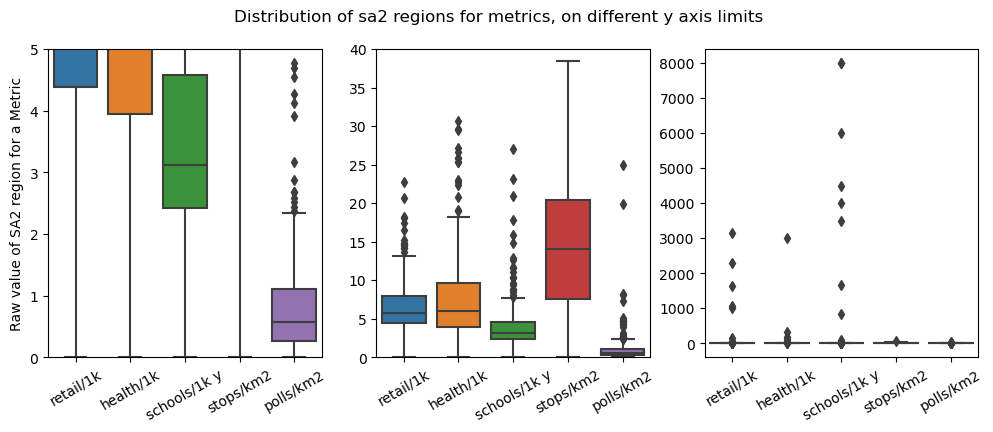

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

sns.boxplot(data=all_aggs_df[
                ["retail_per_1000", "health_per_1000", "schools_per_1000_young", "total_stops_sqkm", "total_polls_sqkm"]],
            ax=ax1)
sns.boxplot(data = all_aggs_df[
                ["retail_per_1000", "health_per_1000", "schools_per_1000_young", "total_stops_sqkm", "total_polls_sqkm"]],
            ax=ax2)
sns.boxplot(data = all_aggs_df[
                ["retail_per_1000", "health_per_1000", "schools_per_1000_young", "total_stops_sqkm", "total_polls_sqkm"]],
            ax=ax3)
ax1.set_ylim(0,5)
ax2.set_ylim(0,40)

labels = ["retail/1k", "health/1k", "schools/1k y", "stops/km2", "polls/km2"]
rot = 30
ax1.set_xticklabels(labels, rotation=rot)
ax2.set_xticklabels(labels, rotation=rot)
ax3.set_xticklabels(labels, rotation=rot)
plt.suptitle("Distribution of sa2 regions for metrics, on different y axis limits")
ax1.set(ylabel='Raw value of SA2 region for a Metric')
plt.show()

Finding mean and standard deviation for all components of well-resourced score in order to later find Z scores. We do so exclusive of outliers with tukey method, considering above plots.

In [24]:
sql = """
CREATE OR REPLACE VIEW metrics AS

WITH metrics_iqr AS (
SELECT
    PERCENTILE_CONT(0.25) within group (ORDER BY retail_per_1000) as "q1_retail",
    PERCENTILE_CONT(0.75) within group (ORDER BY retail_per_1000) as "q3_retail",
    PERCENTILE_CONT(0.25) within group (ORDER BY health_per_1000) as "q1_health",
    PERCENTILE_CONT(0.75) within group (ORDER BY health_per_1000) as "q3_health",
    PERCENTILE_CONT(0.25) within group (ORDER BY schools_per_1000_young) as "q1_schools",
    PERCENTILE_CONT(0.75) within group (ORDER BY schools_per_1000_young) as "q3_schools",
    PERCENTILE_CONT(0.25) within group (ORDER BY total_stops_sqkm) as "q1_stops",
    PERCENTILE_CONT(0.75) within group (ORDER BY total_stops_sqkm) as "q3_stops",
    PERCENTILE_CONT(0.25) within group (ORDER BY total_polls_sqkm) as "q1_polls",
    PERCENTILE_CONT(0.75) within group (ORDER BY total_polls_sqkm) as "q3_polls"
FROM
    all_aggs)
    
SELECT 
    avg(retail_per_1000) as "mean_retail",
    stddev(retail_per_1000) as "sd_retail",
    avg(health_per_1000) as "mean_health",
    stddev(health_per_1000) as "sd_health",
    avg(schools_per_1000_young) as "mean_schools",
    stddev(schools_per_1000_young) as  "sd_schools",
    avg(total_stops_sqkm) as "mean_stops",
    stddev(total_stops_sqkm) as "sd_stops",
    avg(total_polls_sqkm) as "mean_polls",
    stddev(total_polls_sqkm) as "sd_polls"
FROM
    all_aggs
WHERE
    retail_per_1000 > (SELECT q1_retail - (3 * q3_retail - q1_retail) FROM metrics_iqr) AND
    retail_per_1000 < (SELECT q3_retail + (3 * q3_retail - q1_retail) FROM metrics_iqr) AND
    health_per_1000 > (SELECT q1_health - (3 * q3_health - q1_health) FROM metrics_iqr) AND
    health_per_1000 < (SELECT q3_health + (3 * q3_health - q1_health) FROM metrics_iqr) AND
    schools_per_1000_young > (SELECT q1_schools - (3 * q3_schools - q1_schools) FROM metrics_iqr) AND
    schools_per_1000_young < (SELECT q3_schools + (3 * q3_schools - q1_schools)  FROM metrics_iqr) AND
    total_stops_sqkm > (SELECT q1_stops - (3 * q3_stops - q1_stops) FROM metrics_iqr) AND
    total_stops_sqkm < (SELECT q3_stops + (3 * q3_stops - q1_stops) FROM metrics_iqr) AND
    total_polls_sqkm > (SELECT q1_polls - (3 * q3_polls - q1_polls) FROM metrics_iqr) AND
    total_polls_sqkm < (SELECT q3_polls + (3 * q3_polls - q1_polls) FROM metrics_iqr);
    
SELECT *
FROM metrics;
"""

query(conn, sql)

,mean_retail,sd_retail,mean_health,sd_health,mean_schools,sd_schools,mean_stops,sd_stops,mean_polls,sd_polls
0,6.206807,2.760981,7.393061,5.044404,3.577548,2.068603,14.104447,7.909293,0.757054,0.639672


Finally we calculate our z scores, and overall well-resourced score for each sa2 code. We employ score normalisation using the sigmoid function.

In [25]:
# https://stackoverflow.com/questions/34075360/is-there-a-workaround-when-an-underflow-error-occurs-in-postgresql
# We pull sigmoid out as its own function for readability, reusability and error handling 

# OLD FUNCTION
"""
CREATE OR REPLACE FUNCTION sigmoid
    (a DOUBLE PRECISION, b DOUBLE PRECISION, c DOUBLE PRECISION, d DOUBLE PRECISION, e DOUBLE PRECISION, cap INTEGER)
RETURNS DOUBLE PRECISION LANGUAGE plpgsql as $$
BEGIN
    RETURN 1 / (1 + 
                EXP(-1 * 
                (GREATEST(LEAST(a, cap), -1 * cap) + 
                GREATEST(LEAST(b, cap), -1 * cap) + 
                GREATEST(LEAST(c, cap), -1 * cap) + 
                GREATEST(LEAST(d, cap), -1 * cap) + 
                GREATEST(LEAST(e, cap), -1 * cap))
                )
                );
    EXCEPTION when numeric_value_out_of_range THEN 
        RAISE exception 'a=% b=% c=% d=% e=% OUT OF RANGE', a, b, c, d, e;
END $$;  

sigmoid(
    (retail_per_1000 - mean_retail) / sd_retail,
    (health_per_1000 - mean_health) / sd_health, 
    (schools_per_1000_young - mean_schools) / sd_schools,
    (total_stops_sqkm - mean_stops) / sd_stops,
    (total_polls_sqkm - mean_polls) / sd_polls,
    3)
    as "base_score"
"""

# REAL FUNCTION
sql = """
CREATE OR REPLACE FUNCTION sigmoid
    (vals DOUBLE PRECISION[])
RETURNS DOUBLE PRECISION LANGUAGE plpgsql as $$
DECLARE total DOUBLE PRECISION;
DECLARE bound INT;
BEGIN
    total := 0;
    bound := 4;
    FOR i in 1..ARRAY_LENGTH(vals, 1) loop
        total = total + GREATEST(LEAST(vals[i], bound), -1 * bound);
    END loop;
    total = total / ARRAY_LENGTH(vals, 1);
    RETURN 1 / (1 + EXP(-1 * total));
    EXCEPTION when numeric_value_out_of_range THEN 
        RAISE exception 'a=% b=% c=% d=% e=% OUT OF RANGE', a, b, c, d, e;
END $$;  
"""

query(conn, sql)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [26]:
sql = """
DROP TABLE IF EXISTS base_scores;
CREATE TABLE IF NOT EXISTS base_scores as
SELECT 
    sa2_code,
    (retail_per_1000 - mean_retail) / sd_retail 
        as "retail_z",
    (health_per_1000 - mean_health) / sd_health 
        as "health_z",
    (schools_per_1000_young - mean_schools) / sd_schools 
        as "schools_z",
    (total_stops_sqkm - mean_stops) / sd_stops 
        as "stops_z",
    (total_polls_sqkm - mean_polls) / sd_polls 
        as "polls_z",
    ((retail_per_1000 - mean_retail) / sd_retail) + 
        ((health_per_1000 - mean_health) / sd_health) + 
        ((schools_per_1000_young - mean_schools) / sd_schools) +
        ((total_stops_sqkm - mean_stops) / sd_stops) +
        ((total_polls_sqkm - mean_polls) / sd_polls) 
        as "base_sum_z",
    (((retail_per_1000 - mean_retail) / sd_retail) + 
        ((health_per_1000 - mean_health) / sd_health) + 
        ((schools_per_1000_young - mean_schools) / sd_schools) +
        ((total_stops_sqkm - mean_stops) / sd_stops) +
        ((total_polls_sqkm - mean_polls) / sd_polls) * 1/5)
        as "base_mean_z",
     sigmoid(ARRAY[
        (retail_per_1000 - mean_retail) / sd_retail,
        (health_per_1000 - mean_health) / sd_health, 
        (schools_per_1000_young - mean_schools) / sd_schools,
        (total_stops_sqkm - mean_stops) / sd_stops,
        (total_polls_sqkm - mean_polls) / sd_polls])
        as "base_score"
FROM
    all_aggs CROSS JOIN metrics;
    
SELECT *
FROM base_scores
ORDER BY base_score DESC
LIMIT 20;
"""

query(conn, sql)

,sa2_code,retail_z,health_z,schools_z,stops_z,polls_z,base_sum_z,base_mean_z,base_score
0,117031644,50.629319,22.785434,4.370460,3.058057,29.963754,110.807023,86.836020,0.978366
1,117031329,2.894410,3.556617,2.200776,2.643153,11.587068,22.882024,13.612370,0.955169
2,117031645,5.994067,1.535375,0.813181,5.234313,37.862850,51.439786,21.149506,0.946329
3,117031336,5.265149,2.671339,1.305460,1.578297,5.941840,16.762085,12.008613,0.937674
4,119031664,3.091001,1.554605,0.956204,2.752827,10.288857,18.643494,10.412408,0.922078
5,121011684,3.742657,3.658347,-0.390034,1.220602,6.153136,14.384708,9.462199,0.920292
6,118011650,4.061259,4.395156,0.566292,1.784858,1.824579,12.632145,11.172482,0.919468
7,125041717,4.370688,2.319522,1.017242,0.253876,11.410779,19.372107,10.243484,0.910367
8,121041417,3.251900,3.814275,-0.538033,2.708147,2.083241,11.319531,9.652938,0.905843
9,118011341,2.009200,4.415234,-0.029271,2.625741,2.533478,11.554382,9.527600,0.902721


#### OLD MASSIVE JOIN

In [45]:
# this isnt ideal as it will duplicate each row for each catchment, then this set of rows for each stop, then again for each poll
'''
sql="""
CREATE OR REPLACE VIEW joined AS
SELECT *
FROM regions r LEFT JOIN business b USING (sa2_code)
               LEFT JOIN population p USING (sa2_code)
               JOIN catchments c ON ST_INTERSECTS(r.geometry, c.geometry)
               JOIN stops s ON ST_CONTAINS(r.geometry, s.geometry)
               JOIN polls q ON ST_CONTAINS(r.geometry, q.geometry)
GROUP BY ;
               
SELECT *
FROM joined
LIMIT 10;
""" 

query(conn, sql)
'''

'\nsql="""\nCREATE OR REPLACE VIEW joined AS\nSELECT *\nFROM regions r LEFT JOIN business b USING (sa2_code)\n               LEFT JOIN population p USING (sa2_code)\n               JOIN catchments c ON ST_INTERSECTS(r.geometry, c.geometry)\n               JOIN stops s ON ST_CONTAINS(r.geometry, s.geometry)\n               JOIN polls q ON ST_CONTAINS(r.geometry, q.geometry)\nGROUP BY ;\n               \nSELECT *\nFROM joined\nLIMIT 10;\n""" \n\nquery(conn, sql)\n'

In [111]:
#db, conn = pgreconnect(credentials, db, conn, 'sa2', True)

## Task 3: Extending the "Well-Resourced" Score & Score Analysis

### Cleaning and Importing Additional Datasets

To extend the coverage of the score and allow additional analysis, we will import the following four datsets into our database.

#### Points/Features of Interest dataset

The Features of Interest dataset provided by the NSW Department of Customer Service, gives us the location of all the man-made features with cultural significance, split up into 9 different categories depending on their main purpose.
For our analysis, this will allow us to calculate the number of recreational spaces per square km, $z_{recreation}$.

Since GitHub can only store files of less than 100MB the zip file will need to be extracted here:

In [47]:
! unzip -o Points_Of_Interest

Archive:  Points_Of_Interest.zip
  inflating: Points_Of_Interest_EPSG4326.json  


Now, the dataset itself is stored in a geoJSON format, and so we will use the json library to read it:

In [48]:
# Reading the geoJSON file 
features_json = json.loads(open("Points_Of_Interest_EPSG4326.json").read())

features = pd.DataFrame(features_json["Points_Of_Interest"]["features"])
features.head()

,type,geometry,properties
0,Feature,"{'type': 'Point', 'coordinates': [152.12202209...","{'topoid': 500000000, 'poigroup': 9, 'poitype'..."
1,Feature,"{'type': 'Point', 'coordinates': [152.29868781...","{'topoid': 500005504, 'poigroup': 3, 'poitype'..."
2,Feature,"{'type': 'Point', 'coordinates': [152.33785614...","{'topoid': 500005505, 'poigroup': 3, 'poitype'..."
3,Feature,"{'type': 'Point', 'coordinates': [152.34181334...","{'topoid': 500005507, 'poigroup': 3, 'poitype'..."
4,Feature,"{'type': 'Point', 'coordinates': [152.47882472...","{'topoid': 500012781, 'poigroup': 3, 'poitype'..."


As we can see, we will need to expand out the geometry and properties columns. Since all of the locations are provided as points:

In [49]:
# Expanding out the two columns
features_geometry = features["geometry"].apply(pd.Series)
features_properties = features["properties"].apply(pd.Series)

# Combining the two datasets together
features_df = pd.concat([features_geometry[["coordinates"]], features_properties], axis=1)
features_df.head()

,coordinates,topoid,poigroup,poitype,poiname,poilabel,poilabeltype,poialtlabel,poisourcefeatureoid,accesscontrol,startdate,enddate,lastupdate,msoid,centroidid,shapeuuid,changetype,processstate,urbanity
0,"[152.1220220944744, -31.10616338055206]",500000000,9,Mine - Underground,None,Mine - Underground,GENERIC,None,157,1,20210811075603,30000101000000,20210811075657,233046,None,729e2b57-0cd4-3f70-90fa-9dce09e34a8e,I,None,S
1,"[152.29868781096175, -31.021475150297984]",500005504,3,Lookout,KUNDERANG LOOKOUT,KUNDERANG LOOKOUT,NAMED,None,56,1,20100927115312,30000101000000,20100927115312.535000,83091,None,d88a28a8-c572-3992-995f-d26a274aea18,I,None,S
2,"[152.33785614499678, -31.015758874738804]",500005505,3,Lookout,FALLS LOOKOUT,FALLS LOOKOUT,NAMED,None,56,1,20100927115312,30000101000000,20100927115312.535000,83691,None,21b476d2-6519-3e28-8b19-1526fcb9652f,I,None,S
3,"[152.3418133477908, -31.01897423638664]",500005507,3,Lookout,MCCOYS LOOKOUT,MCCOYS LOOKOUT,NAMED,None,56,1,20100927115312,30000101000000,20100927115312.535000,83380,None,016d69b2-6530-39e7-89a6-6e3054df55ac,I,None,S
4,"[152.47882472191145, -31.20753988771374]",500012781,3,Picnic Area,WILSON RIVER PICNIC AREA,WILSON RIVER PICNIC AREA,NAMED,None,62,1,20201223091118,30000101000000,20201223091146.360000,231054,None,49ad26c8-609e-3aa0-b4ad-51459b43ab51,M,None,S


Since for our analysis we are only interested in the number of recreational spaces (such as parks, camping grounds and picnic areas), we will filter the dataset for only the rows that have a poigroup value of 3:

In [50]:
# Selecting only the named recreational places of interest
features_df = features_df[features_df["poigroup"] == 3]
features_df = features_df[features_df["poilabeltype"] == "NAMED"]

# Inspecting 
print(features_df.shape)
print(features_df.dtypes)
features_df.head()

(18974, 19)
coordinates            object
topoid                  int64
poigroup                int64
poitype                object
poiname                object
poilabel               object
poilabeltype           object
poialtlabel            object
poisourcefeatureoid     int64
accesscontrol           int64
startdate              object
enddate                object
lastupdate             object
msoid                   int64
centroidid             object
shapeuuid              object
changetype             object
processstate           object
urbanity               object
dtype: object


,coordinates,topoid,poigroup,poitype,poiname,poilabel,poilabeltype,poialtlabel,poisourcefeatureoid,accesscontrol,startdate,enddate,lastupdate,msoid,centroidid,shapeuuid,changetype,processstate,urbanity
1,"[152.29868781096175, -31.021475150297984]",500005504,3,Lookout,KUNDERANG LOOKOUT,KUNDERANG LOOKOUT,NAMED,None,56,1,20100927115312,30000101000000,20100927115312.535000,83091,None,d88a28a8-c572-3992-995f-d26a274aea18,I,None,S
2,"[152.33785614499678, -31.015758874738804]",500005505,3,Lookout,FALLS LOOKOUT,FALLS LOOKOUT,NAMED,None,56,1,20100927115312,30000101000000,20100927115312.535000,83691,None,21b476d2-6519-3e28-8b19-1526fcb9652f,I,None,S
3,"[152.3418133477908, -31.01897423638664]",500005507,3,Lookout,MCCOYS LOOKOUT,MCCOYS LOOKOUT,NAMED,None,56,1,20100927115312,30000101000000,20100927115312.535000,83380,None,016d69b2-6530-39e7-89a6-6e3054df55ac,I,None,S
4,"[152.47882472191145, -31.20753988771374]",500012781,3,Picnic Area,WILSON RIVER PICNIC AREA,WILSON RIVER PICNIC AREA,NAMED,None,62,1,20201223091118,30000101000000,20201223091146.360000,231054,None,49ad26c8-609e-3aa0-b4ad-51459b43ab51,M,None,S
6,"[152.3862675701802, -31.15257648342038]",500012804,3,Lookout,CROWN ROAD LOOKOUT,CROWN ROAD LOOKOUT,NAMED,None,56,1,20100927115312,30000101000000,20100927115312.535000,83710,None,1c5fb059-d45d-3716-8026-dae996bf718b,I,None,S


We will further clean the table by dropping all of the unnecessary columns:

In [51]:
# Dropping unnecessary columns
features_df = features_df[["coordinates", "topoid", "poitype", "poiname"]]
features_df.head()

,coordinates,topoid,poitype,poiname
1,"[152.29868781096175, -31.021475150297984]",500005504,Lookout,KUNDERANG LOOKOUT
2,"[152.33785614499678, -31.015758874738804]",500005505,Lookout,FALLS LOOKOUT
3,"[152.3418133477908, -31.01897423638664]",500005507,Lookout,MCCOYS LOOKOUT
4,"[152.47882472191145, -31.20753988771374]",500012781,Picnic Area,WILSON RIVER PICNIC AREA
6,"[152.3862675701802, -31.15257648342038]",500012804,Lookout,CROWN ROAD LOOKOUT


Now, we can convert the pandas DataFrame into a GeoDataFrame with geopandas:

In [52]:
# Converting DataFrame to GeoDataFrame
features_gdf = gpd.GeoDataFrame(features_df, geometry=gpd.points_from_xy(features_df.coordinates.str[0], features_df.coordinates.str[1])).set_crs(epsg=4283)
features_gdf.drop("coordinates", axis=1, inplace=True)

# Renaming columns
features_gdf.rename({"topoid":"location_id", "poitype":"location_type", "poiname":"location_name"}, axis=1, inplace=True)

# Setting creating WKT elements for geometry
features_gdf["geometry"] = features_gdf["geometry"].apply(lambda x: create_wkt_element(geom=x,srid=4283))

features_gdf.head()

/home/chris/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1442: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


,location_id,location_type,location_name,geometry
1,500005504,Lookout,KUNDERANG LOOKOUT,POINT (152.29868781096175 -31.021475150297984)
2,500005505,Lookout,FALLS LOOKOUT,POINT (152.33785614499678 -31.015758874738804)
3,500005507,Lookout,MCCOYS LOOKOUT,POINT (152.3418133477908 -31.01897423638664)
4,500012781,Picnic Area,WILSON RIVER PICNIC AREA,POINT (152.47882472191145 -31.20753988771374)
6,500012804,Lookout,CROWN ROAD LOOKOUT,POINT (152.3862675701802 -31.15257648342038)


And finally, we can export the GeoDataFrame to the postgresql database:

In [53]:
# Adding to postgresql database
sql = """
DROP TABLE IF EXISTS features;
CREATE TABLE features (
    location_id INTEGER PRIMARY KEY,
    location_type VARCHAR(50) NOT NULL,
    location_name VARCHAR(100) NOT NULL,
    geometry GEOMETRY(POINT, 4283) NOT NULL
);"""
conn.execute(text(sql))

features_gdf.to_sql('features', conn, schema="sa2", if_exists='append', index=False, dtype={'geometry' : geoalchemy2.Geometry('POINT', srid=4283)})
#features_gdf.to_postgis("features", conn, schema="sa2", if_exists="append", index=False)

query(conn, "SELECT * FROM features LIMIT 5;")

,location_id,location_type,location_name,geometry
0,500005504,Lookout,KUNDERANG LOOKOUT,0101000020BB1000006D79BDD98E096340DF343C657F05...
1,500005505,Lookout,FALLS LOOKOUT,0101000020BB10000071B0B0B7CF0A6340FB9F0BC60804...
2,500005507,Lookout,MCCOYS LOOKOUT,0101000020BB10000021C38B22F00A634048BFDC7EDB04...
3,500012781,Picnic Area,WILSON RIVER PICNIC AREA,0101000020BB10000008243988520F6340955886552135...
4,500012804,Lookout,CROWN ROAD LOOKOUT,0101000020BB100000BDADCE4D5C0C6340E16D9E400F27...


In [54]:
sql = """
DROP INDEX IF EXISTS idx_features_geom;
CREATE INDEX IF NOT EXISTS idx_features_geom on features USING GIST (geometry);

CLUSTER features USING idx_features_geom;
"""
conn.execute(text(sql))

Just like some of the previous datasets added in task 1 this dataset provides us with a single longitude and latitude value for each feature of interest, meaning we will need to check each point to see what SA2 region they are contained within when joining it with the regions dataset.

#### Car Crashes Dataset
Data from https://opendata.transport.nsw.gov.au/dataset/nsw-crash-data

In [63]:
#reading in the data
crashes = pd.read_excel("crashes.xlsx")
print(crashes.shape)
print(crashes.columns)
print(crashes.dtypes)

(101718, 50)
Index(['Crash ID', 'Degree of crash', 'Degree of crash - detailed',
       'Reporting year', 'Year of crash', 'Month of crash',
       'Day of week of crash', 'Two-hour intervals', 'Street of crash',
       'Street type', 'Distance', 'Direction', 'Identifying feature',
       'Identifying feature type', 'Town', 'Route no.', 'School zone location',
       'School zone active', 'Type of location', 'Latitude', 'Longitude',
       'LGA', 'Urbanisation', 'Conurbation 1', 'Alignment',
       'Primary permanent feature', 'Primary temporary feature',
       'Primary hazardous feature', 'Street lighting', 'Road surface',
       'Surface condition', 'Weather', 'Natural lighting', 'Signals operation',
       'Other traffic control', 'Speed limit', 'Road classification (admin)',
       'RUM - code', 'RUM - description', 'DCA - code', 'DCA - description',
       'DCA supplement', 'First impact type', 'Key TU type', 'Other TU type',
       'No. of traffic units involved', 'No. killed', 

Convert DataFrame into GeoDataFrame with geopandas:

In [57]:
#convert into gdf
crashes_gdf = gpd.GeoDataFrame(crashes, geometry = gpd.points_from_xy(crashes.Longitude, crashes.Latitude)).set_crs(epsg=4326)

#remove unnecessary columns and rows
crashes_gdf.columns = [c.lower().replace(' ', '').replace('-', '').replace('.', '') for c in crashes_gdf.columns]
crashes_gdf.drop(crashes_gdf[crashes_gdf.yearofcrash != 2021].index, inplace=True)
crashes_gdf.drop(columns=['latitude', 'longitude', 'streetofcrash', 'streettype', 'twohourintervals', 'distance', 'direction', 'identifyingfeature', 'identifyingfeaturetype', 'town', 'routeno', 'schoolzonelocation', 'schoolzoneactive', 'typeoflocation', 'urbanisation', 'conurbation1', 'alignment', 'primarypermanentfeature', 'primarytemporaryfeature', 'primaryhazardousfeature', 'streetlighting', 'roadsurface', 'surfacecondition', 'weather', 'naturallighting', 'signalsoperation', 'othertrafficcontrol', 'speedlimit', 'roadclassification(admin)', 'rumcode', 'rumdescription', 'dcacode', 'dcadescription', 'dcasupplement', 'firstimpacttype', 'keytutype', 'othertutype', 'reportingyear', 'yearofcrash', 'lga', 'degreeofcrashdetailed'], inplace=True)
crashes_gdf.head()

#setting WKT for import
crashes_gdf["geometry"] = crashes_gdf["geometry"].apply(lambda x: create_wkt_element(geom=x,srid=4326))

/home/chris/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1442: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


Now add into postgresql database

In [58]:
sql = """
DROP TABLE IF EXISTS crashes;
CREATE TABLE crashes (
    crashid INTEGER PRIMARY KEY,
    degreeofcrash VARCHAR(100) NOT NULL,
    monthofcrash VARCHAR(100) NOT NULL,
    dayofweekofcrash VARCHAR(100) NOT NULL,
    nooftrafficunitsinvolved INTEGER NOT NULL,
    nokilled INTEGER NOT NULL,
    noseriouslyinjured INTEGER NOT NULL,
    nomoderatelyinjured INTEGER NOT NULL,
    nominorotherinjured INTEGER NOT NULL,
    geometry GEOMETRY(POINT, 4326) NOT NULL
);
"""
conn.execute(text(sql))

crashes_gdf.to_sql('crashes', conn, schema="sa2", if_exists='append', index=False, dtype={'geometry' : geoalchemy2.Geometry('POINT', srid=4326)})

query(conn, "SELECT * FROM crashes LIMIT 5;")

,crashid,degreeofcrash,monthofcrash,dayofweekofcrash,nooftrafficunitsinvolved,nokilled,noseriouslyinjured,nomoderatelyinjured,nominorotherinjured,geometry
0,1250949,Injury,January,Friday,2,0,1,1,0,0101000020E6100000F1BC546CCCEE624063450DA66168...
1,1251095,Non-casualty (towaway),January,Friday,1,0,0,0,0,0101000020E61000006806F1811DD96240CD5CE0F25845...
2,1251216,Fatal,January,Friday,2,1,0,1,2,0101000020E61000000F45813E91956240FA28232E00FB...
3,1251223,Fatal,January,Tuesday,6,2,2,2,0,0101000020E610000004AE2B66049E62403CA583F57F46...
4,1251228,Fatal,January,Thursday,2,1,0,1,0,0101000020E6100000A96A82A8FBDC624098C3EE3B86F9...


In [59]:
sql = """
DROP INDEX IF EXISTS idx_crashes_geom;
CREATE INDEX IF NOT EXISTS idx_crashes_geom on crashes USING GIST (geometry);

CLUSTER crashes USING idx_crashes_geom;
"""
conn.execute(text(sql))

#### Land Values Dataset

The NSW Valuer General has a website detailing land value metrics in NSW local goverment areas (LGAs). These are read into a data frame using web crawling, and then an ABS spatial dataset is used to read in LGA boundaries. The valuer general robots.txt allows web scraping from this part of the website. Metrics from 2022 are used.

We load in the LGA dataset to add land values to eventually, removing entries not from NSW.

In [33]:
# Loading in LGAs spatial data
land_values_gdf = gpd.read_file('LGA_2022_AUST_GDA94_SHP/LGA_2022_AUST_GDA94.shp')

# Removing entries not from NSW
print(land_values_gdf['STE_NAME21'].value_counts())
land_values_gdf = land_values_gdf[land_values_gdf.STE_NAME21 == "New South Wales"]
land_values_gdf.head()

Western Australia               139
New South Wales                 131
Victoria                         82
Queensland                       80
South Australia                  73
Tasmania                         31
Northern Territory               21
Other Territories                 5
Australian Capital Territory      3
Outside Australia                 1
Name: STE_NAME21, dtype: int64


,LGA_CODE22,LGA_NAME22,STE_CODE21,STE_NAME21,AUS_CODE21,AUS_NAME21,AREASQKM,LOCI_URI21,SHAPE_Leng,SHAPE_Area,geometry
0,10050,Albury,1,New South Wales,AUS,Australia,305.6386,https://linked.data.gov.au/dataset/asgsed3/LGA...,1.321768,0.030560,"POLYGON ((146.86565 -36.07293, 146.86511 -36.0..."
1,10180,Armidale,1,New South Wales,AUS,Australia,7809.4406,https://linked.data.gov.au/dataset/asgsed3/LGA...,6.034583,0.732825,"POLYGON ((152.38816 -30.52641, 152.38812 -30.5..."
2,10250,Ballina,1,New South Wales,AUS,Australia,484.9692,https://linked.data.gov.au/dataset/asgsed3/LGA...,1.511121,0.044843,"MULTIPOLYGON (((153.57106 -28.87382, 153.57105..."
3,10300,Balranald,1,New South Wales,AUS,Australia,21690.7493,https://linked.data.gov.au/dataset/asgsed3/LGA...,11.489913,2.115528,"POLYGON ((143.00432 -33.78165, 143.01538 -33.7..."
4,10470,Bathurst,1,New South Wales,AUS,Australia,3817.8645,https://linked.data.gov.au/dataset/asgsed3/LGA...,5.395114,0.370149,"POLYGON ((149.84877 -33.52785, 149.84863 -33.5..."


After inspecting data, we remove unnecessary columns, special LGAs and any mention to NSW in the LGA name (this will cause downstream issues).

In [34]:
# Dropping irrelevant columns
land_values_gdf.drop(columns=['STE_CODE21', 'STE_NAME21', 'AUS_CODE21', 'AUS_NAME21', 'LOCI_URI21', 'SHAPE_Leng', 'SHAPE_Area'], inplace=True)

# Removing 'NSW' from names, and special LGAs
land_values_gdf = land_values_gdf[~land_values_gdf.LGA_NAME22.isin(['Unincorporated NSW', 'No usual address (NSW)', 'Migratory - Offshore - Shipping (NSW)'])]
land_values_gdf.LGA_NAME22 = land_values_gdf.LGA_NAME22.replace(regex = r' \(?NSW\)?$', value = '')

# Checking data after cleaning 
print(land_values_gdf.dtypes)
land_values_gdf.head()

LGA_CODE22      object
LGA_NAME22      object
AREASQKM       float64
geometry      geometry
dtype: object


,LGA_CODE22,LGA_NAME22,AREASQKM,geometry
0,10050,Albury,305.6386,"POLYGON ((146.86565 -36.07293, 146.86511 -36.0..."
1,10180,Armidale,7809.4406,"POLYGON ((152.38816 -30.52641, 152.38812 -30.5..."
2,10250,Ballina,484.9692,"MULTIPOLYGON (((153.57106 -28.87382, 153.57105..."
3,10300,Balranald,21690.7493,"POLYGON ((143.00432 -33.78165, 143.01538 -33.7..."
4,10470,Bathurst,3817.8645,"POLYGON ((149.84877 -33.52785, 149.84863 -33.5..."


We now prepare for web crawling, requesting page from which we can generate our other URLs.

In [35]:
# Importing web scraping libraries
import requests
import html5lib
from bs4 import BeautifulSoup

# Getting base page
base_page = requests.get('https://www.valuergeneral.nsw.gov.au/land_value_summaries/lga.php').text
base_content = BeautifulSoup(base_page, 'html5lib')

We get all option elements from the select element for LGA in the page, comparing the text for each option against our list of names in the LGA dataset.

In [36]:
# Getting LGA information and checking for data cleaning
lga_codes = base_content.find('select', id='dist_code').findAll('option')
lga_names = [x.text for x in lga_codes]

# Comparing LGA names
print([x for x in lga_names if x not in list(land_values_gdf['LGA_NAME22'])])
print([x for x in land_values_gdf['LGA_NAME22'] if x not in lga_names])

['', 'Armidale Regional', 'Bathurst Regional', 'Cootamundra-Gundagai Regional', 'Dubbo Regional', 'Mid Western Regional', 'Nambucca', 'Queanbeyan-Palerang Regional', 'Snowy Monaro Regional', 'Tamworth Regional', 'The Hills Shire']
['Armidale', 'Bathurst', 'Cootamundra-Gundagai', 'Dubbo', 'Mid-Western', 'Nambucca Valley', 'Queanbeyan-Palerang', 'Snowy Monaro', 'Tamworth', 'The Hills']


Using comparisons between dataset naming conventions, we make modifications to names and create a dictionary to effectively web crawl each required page. We also confirm that their are all 128 LGAs in New South Wales in our dictionary.

In [37]:
# Storing lga name : code mapping
lgas = {}

for option in lga_codes:
    lga_name, lga_code = option.text, option.attrs['value']
    
    # Removing regional from LGA names
    if lga_name.split(' ')[-1] == 'Regional':
        lga_name = ' '.join(lga_name.split(' ')[:-1])
    
    # Dealing with unique cases
    if lga_name == 'Nambucca':
        lga_name = 'Nambucca Valley'
    elif lga_name == 'The Hills Shire':
        lga_name = 'The Hills'
    elif lga_name == 'Mid Western':
        lga_name = 'Mid-Western'
    elif lga_name == '':
        continue

    lgas[lga_name] = lga_code

# Recomparing LGA names, and checking length = 128
print([x for x in lgas.keys() if x not in list(land_values_gdf['LGA_NAME22'])])
print([x for x in land_values_gdf['LGA_NAME22'] if x not in lgas.keys()])
print(lgas)
print(len(lgas))

[]
[]
{'Albury': '050', 'Armidale': '257', 'Ballina': '148', 'Balranald': '230', 'Bathurst': '608', 'Bayside': '276', 'Bega Valley': '018', 'Bellingen': '149', 'Berrigan': '051', 'Blacktown': '214', 'Bland': '231', 'Blayney': '118', 'Blue Mountains': '216', 'Bogan': '232', 'Bourke': '239', 'Brewarrina': '233', 'Broken Hill': '234', 'Burwood': '137', 'Byron': '150', 'Cabonne': '109', 'Camden': '217', 'Campbelltown': '218', 'Canada Bay': '139', 'Canterbury-Bankstown': '258', 'Carrathool': '052', 'Central Coast': '259', 'Central Darling': '235', 'Cessnock': '001', 'Clarence Valley': '303', 'Cobar': '236', 'Coffs Harbour': '152', 'Coolamon': '054', 'Coonamble': '238', 'Cootamundra-Gundagai': '265', 'Cowra': '042', 'Cumberland': '261', 'Dubbo': '275', 'Dungog': '002', 'Edward River': '262', 'Eurobodalla': '097', 'Fairfield': '220', 'Federation': '263', 'Forbes': '117', 'Georges River': '264', 'Gilgandra': '240', 'Glen Innes Severn': '302', 'Goulburn Mulwaree': '529', 'Greater Hume': '560', 

In [38]:
for i, (name, code) in enumerate(lgas.items()):
    lga_url = f'https://www.valuergeneral.nsw.gov.au/land_value_summaries/lga.php?lga={code}&base_date=01072022'
    page = requests.get(lga_url).text
    content = BeautifulSoup(page, 'html5lib')

    # Finding the first table in the website, then the table heading 'total', then its second sibling which has our FY22 total
    total_land_value = content.find('table').find('th', string = 'Total').find_next_siblings()[1].text
    # Removing symbols, as all total land values are whole numbers
    total_land_value = int(re.sub('\D', '', total_land_value))

    # Finding the contents of the first script in the panel group (this generates median chart)
    chart_script = content.find('div', class_='panel-group').script.string
    # We remove newlines from script, and then non-greedily look for a string matching data.addRows([anything])
    chart_script = chart_script.replace('\n', '')
    pattern = "data.addRows\(.*?\)"
    data = re.findall(pattern, chart_script)[0]
    # Using the first hit for this pattern, we split the data for the chart by the unique '2022,' which also indicates our data
    # We can then split again by ',' to find our metrics from the data for the chart
    median_land_value, median_sale_price = data.split("'2022',")[1].split(',')[0:2]
    
    # Setting new attributes
    land_values_gdf.loc[land_values_gdf['LGA_NAME22'] == name, 'TOTAL_LAND_VALUE22'] = total_land_value
    land_values_gdf.loc[land_values_gdf['LGA_NAME22'] == name, 'MEDIAN_LAND_VALUE22'] = median_land_value
    land_values_gdf.loc[land_values_gdf['LGA_NAME22'] == name, 'MEDIAN_SALE_PRICE22'] = median_sale_price

    print(f"Scraped {i+1}/{len(lgas)}: {lga_url}")
    t.sleep(random.uniform(1.00,3.00))

land_values_gdf.head()

Scraped 1/128: https://www.valuergeneral.nsw.gov.au/land_value_summaries/lga.php?lga=050&base_date=01072022
Scraped 2/128: https://www.valuergeneral.nsw.gov.au/land_value_summaries/lga.php?lga=257&base_date=01072022
Scraped 3/128: https://www.valuergeneral.nsw.gov.au/land_value_summaries/lga.php?lga=148&base_date=01072022
Scraped 4/128: https://www.valuergeneral.nsw.gov.au/land_value_summaries/lga.php?lga=230&base_date=01072022
Scraped 5/128: https://www.valuergeneral.nsw.gov.au/land_value_summaries/lga.php?lga=608&base_date=01072022
Scraped 6/128: https://www.valuergeneral.nsw.gov.au/land_value_summaries/lga.php?lga=276&base_date=01072022
Scraped 7/128: https://www.valuergeneral.nsw.gov.au/land_value_summaries/lga.php?lga=018&base_date=01072022
Scraped 8/128: https://www.valuergeneral.nsw.gov.au/land_value_summaries/lga.php?lga=149&base_date=01072022
Scraped 9/128: https://www.valuergeneral.nsw.gov.au/land_value_summaries/lga.php?lga=051&base_date=01072022
Scraped 10/128: https://www.

Scraped 77/128: https://www.valuergeneral.nsw.gov.au/land_value_summaries/lga.php?lga=087&base_date=01072022
Scraped 78/128: https://www.valuergeneral.nsw.gov.au/land_value_summaries/lga.php?lga=269&base_date=01072022
Scraped 79/128: https://www.valuergeneral.nsw.gov.au/land_value_summaries/lga.php?lga=270&base_date=01072022
Scraped 80/128: https://www.valuergeneral.nsw.gov.au/land_value_summaries/lga.php?lga=007&base_date=01072022
Scraped 81/128: https://www.valuergeneral.nsw.gov.au/land_value_summaries/lga.php?lga=164&base_date=01072022
Scraped 82/128: https://www.valuergeneral.nsw.gov.au/land_value_summaries/lga.php?lga=247&base_date=01072022
Scraped 83/128: https://www.valuergeneral.nsw.gov.au/land_value_summaries/lga.php?lga=070&base_date=01072022
Scraped 84/128: https://www.valuergeneral.nsw.gov.au/land_value_summaries/lga.php?lga=251&base_date=01072022
Scraped 85/128: https://www.valuergeneral.nsw.gov.au/land_value_summaries/lga.php?lga=008&base_date=01072022
Scraped 86/128: htt

,LGA_CODE22,LGA_NAME22,AREASQKM,geometry,TOTAL_LAND_VALUE22,MEDIAN_LAND_VALUE22,MEDIAN_SALE_PRICE22
0,10050,Albury,305.6386,"POLYGON ((146.86565 -36.07293, 146.86511 -36.0...",7.257851e+09,196000,485000
1,10180,Armidale,7809.4406,"POLYGON ((152.38816 -30.52641, 152.38812 -30.5...",6.469390e+09,187000,445000
2,10250,Ballina,484.9692,"MULTIPOLYGON (((153.57106 -28.87382, 153.57105...",1.510484e+10,670000,1100000
3,10300,Balranald,21690.7493,"POLYGON ((143.00432 -33.78165, 143.01538 -33.7...",9.918624e+08,55000,130000
4,10470,Bathurst,3817.8645,"POLYGON ((149.84877 -33.52785, 149.84863 -33.5...",8.166204e+09,303000,655000


We clean and prepare our dataset in preparation for loading into our database.

In [39]:
# Fixing data types and column names for SQL
print(land_values_gdf.dtypes)
land_values_gdf = land_values_gdf.astype({"LGA_CODE22" : "int64", 
                                  "TOTAL_LAND_VALUE22" : "int64", 
                                  "MEDIAN_LAND_VALUE22" : "int64", 
                                  "MEDIAN_SALE_PRICE22" : "int64"})
land_values_gdf.rename(columns=lambda col : col.lower(), inplace=True)
print(land_values_gdf.head())

# Ensuring all geometries are multipolygons
land_values_gdf["geometry"] = land_values_gdf["geometry"].apply(lambda x: create_wkt_element(geom=x,srid=4283))

# Checking attribute max sizes to inform SQL table variables
land_values_gdf.max()

LGA_CODE22               object
LGA_NAME22               object
AREASQKM                float64
geometry               geometry
TOTAL_LAND_VALUE22      float64
MEDIAN_LAND_VALUE22      object
MEDIAN_SALE_PRICE22      object
dtype: object
   lga_code22 lga_name22    areasqkm  \
0       10050     Albury    305.6386   
1       10180   Armidale   7809.4406   
2       10250    Ballina    484.9692   
3       10300  Balranald  21690.7493   
4       10470   Bathurst   3817.8645   

                                            geometry  total_land_value22  \
0  POLYGON ((146.86565 -36.07293, 146.86511 -36.0...          7257850520   
1  POLYGON ((152.38816 -30.52641, 152.38812 -30.5...          6469389930   
2  MULTIPOLYGON (((153.57106 -28.87382, 153.57105...         15104844721   
3  POLYGON ((143.00432 -33.78165, 143.01538 -33.7...           991862450   
4  POLYGON ((149.84877 -33.52785, 149.84863 -33.5...          8166203660   

   median_land_value22  median_sale_price22  
0               19

/Users/lukamelvin/opt/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1442: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")
/var/folders/y9/v_7cr0n54kj19wdhjydql0w80000gn/T/ipykernel_69592/3388622153.py:14: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  land_values_gdf.max()


lga_code22                    18710
lga_name22              Yass Valley
areasqkm                  53492.193
total_land_value22     148770044214
median_land_value22         3440000
median_sale_price22         4750000
dtype: object

We finally define and fill our SQL table by loading in our dataset.

In [40]:
#db, conn = pgreconnect(credentials, db, conn, 'sa2', True)

In [41]:
sql = """
DROP TABLE IF EXISTS values;
CREATE TABLE IF NOT EXISTS values (
    lga_code22 INTEGER PRIMARY KEY,
    lga_name22 VARCHAR(50) UNIQUE NOT NULL,
    total_land_value22 BIGINT NOT NULL,
    median_land_value22 INTEGER NOT NULL,
    median_sale_price22 INTEGER NOT NULL,
    areasqkm FLOAT NOT NULL,
    geometry GEOMETRY(MULTIPOLYGON, 4283) NOT NULL
)
"""
conn.execute(text(sql))

land_values_gdf.to_sql('values', conn, schema='sa2', if_exists='append', index=False, dtype={'geometry' : geoalchemy2.Geometry('MULTIPOLYGON', srid=4283)})

query(conn, "SELECT * FROM values LIMIT 5;")

,lga_code22,lga_name22,total_land_value22,median_land_value22,median_sale_price22,areasqkm,geometry
0,10050,Albury,7257850520,196000,485000,305.6386,0106000020BB10000001000000010300000001000000B6...
1,10180,Armidale,6469389930,187000,445000,7809.4406,0106000020BB10000001000000010300000001000000A5...
2,10250,Ballina,15104844721,670000,1100000,484.9692,0106000020BB100000020000000103000000010000009C...
3,10300,Balranald,991862450,55000,130000,21690.7493,0106000020BB10000001000000010300000001000000A2...
4,10470,Bathurst,8166203660,303000,655000,3817.8645,0106000020BB1000000100000001030000000100000095...


In [42]:
sql = """
DROP INDEX IF EXISTS idx_values_geom;
CREATE INDEX IF NOT EXISTS idx_values_geom on values USING GIST (geometry);

CLUSTER values USING idx_values_geom;
"""
conn.execute(text(sql))

In [77]:
#db, conn = pgreconnect(credentials, db, conn, 'sa2', True)

#### Income dataset
To guage the usefulness of the calculated scores, we will use the median income of each SA2 region to later perform a correlation analysis between these scores.
 
To do so, we will first need to import the Income dataset. The table itself is provided as a csv, so we will read it in using pandas:

In [78]:
income = pd.read_csv("Income.csv")
print(income.shape)
print(income.columns)


# Filtering for only the entries with income data in greater Sydney
income = income[(income["earners"]!="np") & (income["median_age"]!="np")
        & (income["median_income"]!="np") & (income["mean_income"]!="np")]
income = income.loc[income["sa2_code"].isin(regions["sa2_code"])]

# Correcting datatypes
income = income.astype({"earners":"int64", "median_age":"int64", "median_income":"int64", "mean_income":"int64"})
print(income.dtypes)

# Removing unnecessary columns
income.drop("sa2_name", axis=1, inplace=True)

(576, 6)
Index(['sa2_code', 'sa2_name', 'earners', 'median_age', 'median_income',
       'mean_income'],
      dtype='object')
sa2_code          int64
sa2_name         object
earners           int64
median_age        int64
median_income     int64
mean_income       int64
dtype: object


After cleaning the dataset, we can finally export it to the database:

In [79]:
# Adding to postgresql database
sql = """
DROP TABLE IF EXISTS income;
CREATE TABLE income (
    sa2_code INTEGER PRIMARY KEY REFERENCES regions (sa2_code),
    earners INTEGER NOT NULL,
    median_age INTEGER NOT NULL,
    median_income INTEGER NOT NULL,
    mean_income INTEGER NOT NULL
);"""
conn.execute(sql);

income.to_sql("income", conn, schema="sa2", if_exists="append", index=False)

query(conn, "SELECT * FROM income LIMIT 5;")

,sa2_code,earners,median_age,median_income,mean_income
0,102011028,4788,47,52450,71977
1,102011029,6647,49,48724,64621
2,102011030,2919,49,46228,61545
3,102011031,7962,48,48292,67162
4,102011032,11439,42,51999,62478


In [80]:
sql = """
DROP INDEX IF EXISTS idx_income_sa2;
CREATE INDEX IF NOT EXISTS idx_income_sa2 on income USING BTREE (sa2_code);

CLUSTER income USING idx_income_sa2;
"""
conn.execute(text(sql))

This dataset contains an explicit sa2_code column, so we can directly join it with the sa2_code column in the regions dataset when performing the analysis.

In [81]:
#db, conn = pgreconnect(credentials, db, conn, 'sa2', True)

### Extending 'Well-Resourced' Score

We add our features, crashes, and land values datasets in, replicating task 2 and extending our score.

In [43]:
# need to take average of populations, as multiple rows with same popn found for each intersecting catchment
# and to ensure counts arent interfered with we take only one industry code 
# if no young people in a sa2 code, THEN -1 RETURNED FOR NOW
sql="""
CREATE OR REPLACE VIEW features_agg AS
SELECT 
    r.sa2_code,
    count(f.location_id) as "total_features",
    CASE
        WHEN r.area_sqkm = 0 THEN 0
        ELSE count(f.location_id)::float/r.area_sqkm
    END as "total_features_sqkm"
FROM 
    regions r LEFT JOIN features f ON ST_CONTAINS(r.geometry, ST_TRANSFORM(f.geometry, 7844))
GROUP BY
    r.sa2_code, r.area_sqkm;
    
CREATE OR REPLACE VIEW crashes_agg AS
SELECT 
    n.sa2_code,
    count(c.crashid) as "total_crashes",
    CASE
        WHEN n.total_people::float = 0 THEN 0
        ELSE count(c.crashid)::float/n.total_people::float * 1000
    END as "total_crashes_per_1000"
FROM 
    non_spat_join n LEFT JOIN crashes c ON ST_CONTAINS(n.geometry, ST_TRANSFORM(c.geometry, 7844))
WHERE
    n.industry_code = 'G'
GROUP BY
    n.sa2_code, n.total_people;
    
CREATE OR REPLACE VIEW values_agg AS
SELECT 
    r.sa2_code,
    avg(v.median_land_value22) as "median_value",
    avg(v.median_sale_price22) as "median_sale",
    CASE
        WHEN sum(v.areasqkm) = 0 THEN 0
        ELSE sum(v.total_land_value22)::float/sum(v.areasqkm)
    END as "land_value_sqkm"
FROM 
    regions r LEFT JOIN values v ON ST_INTERSECTS(r.geometry, ST_TRANSFORM(v.geometry, 7844))
GROUP BY
    r.sa2_code;
    
SELECT *
FROM features_agg FULL OUTER JOIN crashes_agg USING (sa2_code) FULL OUTER JOIN values_agg USING (sa2_code)
LIMIT 10;
""" 

query(conn, sql)

,sa2_code,total_features,total_features_sqkm,total_crashes,total_crashes_per_1000,median_value,median_sale,land_value_sqkm
0,102011028,24,3.728097,7,0.929615,558000.0,950000.0,5.603935e+07
1,102011029,53,1.652109,19,1.719146,558000.0,950000.0,5.603935e+07
2,102011030,56,0.072921,99,20.850885,663750.0,1060000.0,2.742052e+07
3,102011031,39,1.154072,33,2.229278,558000.0,950000.0,5.603935e+07
4,102011032,60,3.547714,77,3.607233,558000.0,950000.0,5.603935e+07
5,102011033,11,1.324296,9,1.380792,558000.0,950000.0,5.603935e+07
6,102011034,19,1.621589,19,2.490823,558000.0,950000.0,5.603935e+07
7,102011035,23,2.986199,8,1.112502,558000.0,950000.0,5.603935e+07
8,102011036,23,1.374644,20,2.428068,558000.0,950000.0,5.603935e+07
9,102011037,15,2.212585,12,1.825095,558000.0,950000.0,5.603935e+07


In [44]:
sql = """
DROP TABLE IF EXISTS extended_aggs CASCADE;
CREATE TABLE IF NOT EXISTS extended_aggs AS
SELECT
    *
FROM
    all_aggs FULL OUTER JOIN features_agg USING (sa2_code)
               FULL OUTER JOIN crashes_agg USING (sa2_code)
               FULL OUTER JOIN values_agg USING (sa2_code);
               
SELECT *
FROM extended_aggs
LIMIT 10;
"""

query(conn, sql)

,sa2_code,total_retail,retail_per_1000,total_health,health_per_1000,total_schools,schools_per_1000_young,total_stops,total_stops_sqkm,total_polls,total_polls_sqkm,total_features,total_features_sqkm,total_crashes,total_crashes_per_1000,median_value,median_sale,land_value_sqkm
0,102011028,45,5.976096,74,9.827357,6,2.828854,65,10.096931,2,0.310675,24,3.728097,7,0.929615,558000.0,950000.0,5.603935e+07
1,102011029,51,4.614549,59,5.338400,7,2.832861,114,3.553594,2,0.062344,53,1.652109,19,1.719146,558000.0,950000.0,5.603935e+07
2,102011030,49,10.320135,43,9.056445,26,27.055151,95,0.123706,7,0.009115,56,0.072921,99,20.850885,663750.0,1060000.0,2.742052e+07
3,102011031,144,9.727758,204,13.780990,17,5.304212,150,4.438737,6,0.177549,39,1.154072,33,2.229278,558000.0,950000.0,5.603935e+07
4,102011032,174,8.151410,300,14.054155,14,3.208066,191,11.293556,7,0.413900,60,3.547714,77,3.607233,558000.0,950000.0,5.603935e+07
5,102011033,24,3.682111,21,3.221847,4,2.020202,34,4.093279,2,0.240781,11,1.324296,9,1.380792,558000.0,950000.0,5.603935e+07
6,102011034,39,5.112743,56,7.341374,6,3.374578,79,6.742398,4,0.341387,19,1.621589,19,2.490823,558000.0,950000.0,5.603935e+07
7,102011035,16,2.225003,24,3.337505,7,3.560529,59,7.660249,1,0.129835,23,2.986199,8,1.112502,558000.0,950000.0,5.603935e+07
8,102011036,29,3.520699,25,3.035086,12,5.221932,57,3.406727,1,0.059767,23,1.374644,20,2.428068,558000.0,950000.0,5.603935e+07
9,102011037,22,3.346008,36,5.475285,4,2.647253,83,12.242971,2,0.295011,15,2.212585,12,1.825095,558000.0,950000.0,5.603935e+07


In [45]:
ext_aggs_df = query(conn, "SELECT * FROM extended_aggs")

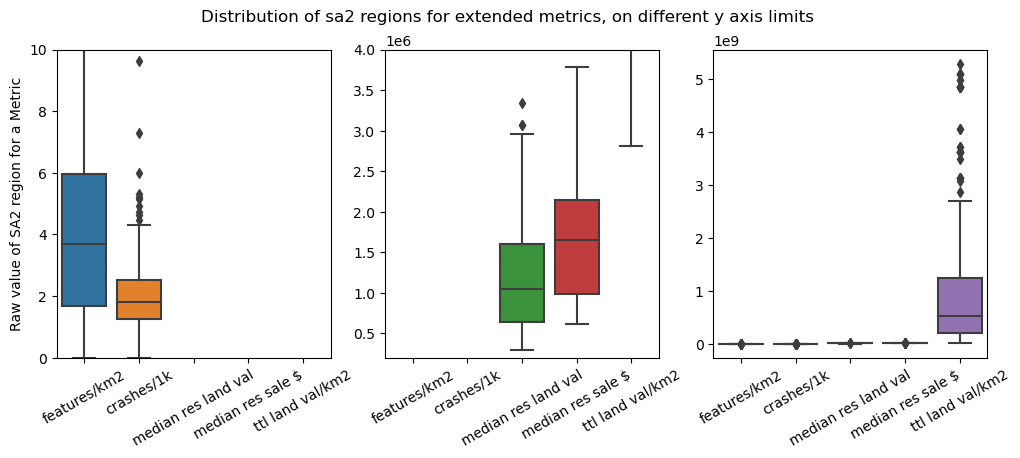

In [46]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

sns.boxplot(data=ext_aggs_df[
                ["total_features_sqkm", "total_crashes_per_1000", "median_value", "median_sale", "land_value_sqkm"]],
            ax=ax1)
sns.boxplot(data = ext_aggs_df[
                ["total_features_sqkm", "total_crashes_per_1000", "median_value", "median_sale", "land_value_sqkm"]],
            ax=ax2)
sns.boxplot(data = ext_aggs_df[
                ["total_features_sqkm", "total_crashes_per_1000", "median_value", "median_sale", "land_value_sqkm"]],
            ax=ax3)
ax1.set_ylim(0,10)
ax2.set_ylim(200000,4000000)

labels = ["features/km2", "crashes/1k", "median res land val", "median res sale $", "ttl land val/km2"]
rot = 30
ax1.set_xticklabels(labels, rotation=rot)
ax2.set_xticklabels(labels, rotation=rot)
ax3.set_xticklabels(labels, rotation=rot)
plt.suptitle("Distribution of sa2 regions for extended metrics, on different y axis limits")
ax1.set(ylabel='Raw value of SA2 region for a Metric')
plt.show()

In [47]:
sql = """
CREATE OR REPLACE VIEW extended_metrics AS
WITH extended_metrics_iqr AS (
SELECT
    PERCENTILE_CONT(0.25) within group (ORDER BY total_features_sqkm) as "q1_features",
    PERCENTILE_CONT(0.75) within group (ORDER BY total_features_sqkm) as "q3_features",
    PERCENTILE_CONT(0.25) within group (ORDER BY total_crashes_per_1000) as "q1_crashes",
    PERCENTILE_CONT(0.75) within group (ORDER BY total_crashes_per_1000) as "q3_crashes",
    PERCENTILE_CONT(0.25) within group (ORDER BY median_value) as "q1_mvalue",
    PERCENTILE_CONT(0.75) within group (ORDER BY median_value) as "q3_mvalue",
    PERCENTILE_CONT(0.25) within group (ORDER BY median_sale) as "q1_msale",
    PERCENTILE_CONT(0.75) within group (ORDER BY median_sale) as "q3_msale",
    PERCENTILE_CONT(0.25) within group (ORDER BY land_value_sqkm) as "q1_tvalue",
    PERCENTILE_CONT(0.75) within group (ORDER BY land_value_sqkm) as "q3_tvalue"
FROM
    extended_aggs)
    
SELECT 
    avg(total_features_sqkm) as "mean_features",
    stddev(total_features_sqkm) as "sd_features",
    avg(total_crashes_per_1000) as "mean_crashes",
    stddev(total_crashes_per_1000) as "sd_crashes",
    avg(median_value) as "mean_mvalue",
    stddev(median_value) as  "sd_mvalue",
    avg(median_sale) as "mean_msale",
    stddev(median_sale) as "sd_msale",
    avg(land_value_sqkm) as "mean_tvalue",
    stddev(land_value_sqkm) as "sd_tvalue"
FROM
    extended_aggs
WHERE
    total_features_sqkm > (SELECT q1_features - (3 * q3_features - q1_features) FROM extended_metrics_iqr) AND
    total_features_sqkm < (SELECT q3_features + (3 * q3_features - q1_features) FROM extended_metrics_iqr) AND
    total_crashes_per_1000 > (SELECT q1_crashes - (3 * q3_crashes - q1_crashes) FROM extended_metrics_iqr) AND
    total_crashes_per_1000 < (SELECT q3_crashes + (3 * q3_crashes - q1_crashes) FROM extended_metrics_iqr) AND
    median_value > (SELECT q1_mvalue - (3 * q3_mvalue - q1_mvalue) FROM extended_metrics_iqr) AND
    median_value < (SELECT q3_mvalue + (3 * q3_mvalue - q1_mvalue)  FROM extended_metrics_iqr) AND
    median_sale > (SELECT q1_msale - (3 * q3_msale - q1_msale) FROM extended_metrics_iqr) AND
    median_sale < (SELECT q3_msale + (3 * q3_msale - q1_msale) FROM extended_metrics_iqr) AND
    land_value_sqkm > (SELECT q1_tvalue - (3 * q3_tvalue - q1_tvalue) FROM extended_metrics_iqr) AND
    land_value_sqkm < (SELECT q3_tvalue + (3 * q3_tvalue - q1_tvalue) FROM extended_metrics_iqr);

CREATE OR REPLACE VIEW full_metrics AS
SELECT
    *
FROM
    metrics JOIN extended_metrics ON (TRUE);
    
SELECT *
FROM full_metrics;
"""

query(conn, sql)

,mean_retail,sd_retail,mean_health,sd_health,mean_schools,sd_schools,mean_stops,sd_stops,mean_polls,sd_polls,mean_features,sd_features,mean_crashes,sd_crashes,mean_mvalue,sd_mvalue,mean_msale,sd_msale,mean_tvalue,sd_tvalue
0,6.206807,2.760981,7.393061,5.044404,3.577548,2.068603,14.104447,7.909293,0.757054,0.639672,4.276361,3.42299,1.934215,1.023883,1.153364e+06,570565.557133,1.647717e+06,742076.184614,8.485216e+08,9.277031e+08


In [48]:
sql = """
DROP TABLE IF EXISTS extended_scores;
CREATE TABLE IF NOT EXISTS extended_scores as
SELECT 
    b.*,
    (total_features_sqkm - mean_features) / sd_features 
        as "features_z",
    (total_crashes_per_1000 - mean_crashes) / sd_crashes 
        as "crash_z",
    (median_value - mean_mvalue) / sd_mvalue 
        as "mvalue_z",
    (median_sale - mean_msale) / sd_msale 
        as "msale_z",
    (land_value_sqkm - mean_tvalue) / sd_tvalue 
        as "tvalue_z",
    ((retail_per_1000 - mean_retail) / sd_retail) + 
        ((health_per_1000 - mean_health) / sd_health) + 
        ((schools_per_1000_young - mean_schools) / sd_schools) +
        ((total_stops_sqkm - mean_stops) / sd_stops) +
        ((total_polls_sqkm - mean_polls) / sd_polls) +
        ((total_features_sqkm - mean_features) / sd_features) + 
        ((total_crashes_per_1000 - mean_crashes) / sd_crashes) + 
        ((median_value - mean_mvalue) / sd_mvalue) +
        ((median_sale - mean_msale) / sd_msale) +
        ((land_value_sqkm - mean_tvalue) / sd_tvalue) 
        as "ext_sum_z",
    (((retail_per_1000 - mean_retail) / sd_retail) + 
        ((health_per_1000 - mean_health) / sd_health) + 
        ((schools_per_1000_young - mean_schools) / sd_schools) +
        ((total_stops_sqkm - mean_stops) / sd_stops) +
        ((total_polls_sqkm - mean_polls) / sd_polls) +
        ((total_features_sqkm - mean_features) / sd_features) + 
        ((total_crashes_per_1000 - mean_crashes) / sd_crashes) + 
        ((median_value - mean_mvalue) / sd_mvalue) +
        ((median_sale - mean_msale) / sd_msale) +
        ((land_value_sqkm - mean_tvalue) / sd_tvalue) * 1/10)
        as "ext_mean_z",
    sigmoid(ARRAY[
        (retail_per_1000 - mean_retail) / sd_retail,
        (health_per_1000 - mean_health) / sd_health, 
        (schools_per_1000_young - mean_schools) / sd_schools,
        (total_stops_sqkm - mean_stops) / sd_stops,
        (total_polls_sqkm - mean_polls) / sd_polls,
        (total_features_sqkm - mean_features) / sd_features,
        (total_crashes_per_1000 - mean_crashes) / sd_crashes, 
        (median_value - mean_mvalue) / sd_mvalue,
        (median_sale - mean_msale) / sd_msale,
        (land_value_sqkm - mean_tvalue) / sd_tvalue])
        as "extended_score"
FROM
    base_scores b RIGHT JOIN extended_aggs e USING (sa2_code) CROSS JOIN full_metrics;
    
SELECT *
FROM extended_scores 
ORDER BY extended_score DESC
LIMIT 40;
"""

query(conn, sql)

,sa2_code,retail_z,health_z,schools_z,stops_z,polls_z,base_sum_z,base_mean_z,base_score,features_z,crash_z,mvalue_z,msale_z,tvalue_z,ext_sum_z,ext_mean_z,extended_score
0,117031644,50.629319,22.785434,4.370460,3.058057,29.963754,110.807023,86.836020,0.978366,4.298505,7.521469,0.274528,0.384439,4.310115,127.596080,123.716976,0.959755
1,121041417,3.251900,3.814275,-0.538033,2.708147,2.083241,11.319531,9.652938,0.905843,5.008051,0.673332,2.710707,2.388277,3.468277,25.568175,22.446725,0.921000
2,118011341,2.009200,4.415234,-0.029271,2.625741,2.533478,11.554382,9.527600,0.902721,1.066068,0.516234,3.166395,3.483178,4.574179,24.360436,20.243675,0.911904
3,117031329,2.894410,3.556617,2.200776,2.643153,11.587068,22.882024,13.612370,0.955169,2.159987,1.192465,0.274528,0.384439,4.310115,31.203557,27.324454,0.911383
4,118011650,4.061259,4.395156,0.566292,1.784858,1.824579,12.632145,11.172482,0.919468,1.373997,0.249746,2.053464,2.090464,4.462918,22.862734,18.846108,0.899740
5,117031336,5.265149,2.671339,1.305460,1.578297,5.941840,16.762085,12.008613,0.937674,1.413796,-0.003039,0.274528,0.384439,4.310115,23.141924,19.262821,0.876801
6,117031645,5.994067,1.535375,0.813181,5.234313,37.862850,51.439786,21.149506,0.946329,0.642457,-0.064974,0.274528,0.384439,4.310115,56.986351,53.107248,0.876371
7,118011347,1.429012,3.089198,0.234332,0.981379,1.258200,6.992121,5.985561,0.801934,1.032165,-0.323497,3.166395,3.483178,4.574179,18.924541,14.807779,0.862361
8,121041416,0.655158,1.117998,-0.522415,1.189480,3.764544,6.204765,3.193129,0.775730,4.034512,-0.706343,2.710707,2.388277,3.468277,18.100195,14.978745,0.858947
9,121011684,3.742657,3.658347,-0.390034,1.220602,6.153136,14.384708,9.462199,0.920292,0.978629,0.185779,2.000885,1.970530,0.391341,19.911872,19.559665,0.855187


In [118]:
#db, conn = pgreconnect(credentials, db, conn, 'sa2', True)

### Exporting Data and Producing Visualisations

### Correlation Analysis

We will now see if there is any correlation between our z scores and median income of each region

In [49]:
sql = '''
SELECT 
    corr(base_score, median_income) AS "Correlation between base score and median income",
    corr(extended_score, median_income) AS "Correlation between extended score and median income"
FROM 
    extended_scores INNER JOIN income USING (sa2_code)
'''

query(conn, sql)

,Correlation between base score and median income,Correlation between extended score and median income
0,0.34646,0.482006


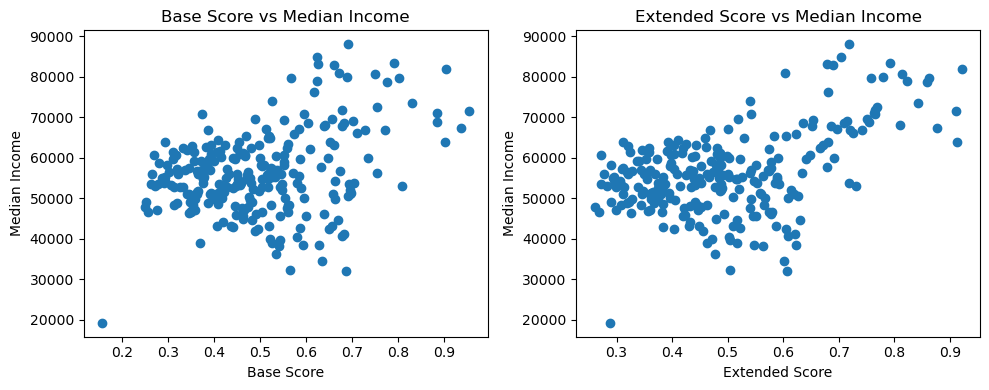

In [68]:
#Producing scatter plot

scatter_plot_data = query(conn, "SELECT * FROM extended_scores INNER JOIN income USING (sa2_code)", df=True)

base_score = scatter_plot_data['base_score']
extended_score = scatter_plot_data['extended_score']
median_income = scatter_plot_data['median_income']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].scatter(base_score, median_income)
axes[0].set_xlabel('Base Score')
axes[0].set_ylabel('Median Income')
axes[0].set_title('Base Score vs Median Income')

axes[1].scatter(extended_score, median_income)
axes[1].set_xlabel('Extended Score')
axes[1].set_ylabel('Median Income')
axes[1].set_title("Extended Score vs Median Income")

plt.tight_layout()

plt.show()

## Task 4:  Further Analysis

### Calculating 'Well-Resourced' Score Using Ranks

My thoughts:

$r_i=$ rank of each metric
$n=$ total number of rows
$k=$ total number of metrics

Simple choice - give each metric a score by subtracting the rank from the total number of rows, then standardise to [0,1]
$$
\text{Score} = \frac{1}{kn}\sum_{i=1}^{k}(n-r_i+1) = 1+\frac{1}{n}-\frac{1}{kn}\sum_{i=1}^{k}r_i
$$
- Ensures that all values are within [0,1]
- All metrics are weighted equally here (although we will work out weightings in ML part)

Analysis
- compute correlation between rank scores and median income
- plot the two scores against each other, plot regression line and compute $R^2$

### Producing a Machine Learning Model
In this section, we will systematically determine the relative importance of each of the different metrics used when calculating the final score, trying to answer the follow research questions:
- Which metrics are the most beneficial in predicting the median income if each SA2 region?
- How should the different metrics be weighted within the sigmoid and ranking functions in order to minimise the prediction error?

To do this, we will use a random forests regression model from the sciki-learn library to try and predict the median income for each SA2 region:

In [1]:
# Imports
import math
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

We first need to import both of the datasets created in the previous tasks from the database:

In [25]:
# Importing the joined dataset to pandas
aggs = query(conn, "SELECT * FROM extended_scores", df=True)
aggs.head()

,sa2_code,retail_z,health_z,schools_z,stops_z,polls_z,base_sum_z,base_score,features_z,crash_z,mvalue_z,msale_z,tvalue_z
0,102011028,-0.083562,0.482574,-0.361932,-0.506684,-0.699484,-1.169088,0.237020,-0.180290,-0.987603,-1.055815,-0.948127,-0.811503
1,102011029,-0.576700,-0.407315,-0.359995,-1.333982,-1.089237,-3.767229,0.022594,-0.803067,-0.211056,-1.055815,-0.948127,-0.811503
2,102011030,1.489806,0.329748,11.349496,-1.767635,-1.172779,10.228636,0.867512,-1.276808,18.606058,-0.871914,-0.802447,-0.837809
3,102011031,1.275253,1.266340,0.834700,-1.222070,-0.908423,1.245801,0.776572,-0.952474,0.290687,-1.055815,-0.948127,-0.811503
4,102011032,0.704316,1.320492,-0.178614,-0.355391,-0.537473,0.953330,0.721784,-0.234403,1.645981,-1.055815,-0.948127,-0.811503


In [26]:
# Importing income dataset
income = query(conn, "SELECT * FROM income", df=True)

income.head()

,sa2_code,earners,median_age,median_income,mean_income
0,102011028,4788,47,52450,71977
1,102011029,6647,49,48724,64621
2,102011030,2919,49,46228,61545
3,102011031,7962,48,48292,67162
4,102011032,11439,42,51999,62478


Since scikit-learn models do not work with NULL values present, we need to remove all of the SA2 regions that have no income data:

In [27]:
# Removing SA2 regions with no income data
aggs = aggs.loc[aggs["sa2_code"].isin(income["sa2_code"])]

X = aggs.drop(["base_score", "sa2_code"], axis=1).fillna(0)
y = income["median_income"].dropna()

To maintain the validity of our work, we will split up the data into two sets:
- A training set to train the model (uses 90% of the total data available)
- A test set to be able to score the model on how well it could predict the median income on unseen data (uses 10% of the total data available)

In [10]:
# Splitting the data into training and setting sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=21)

To maximise the accuracy of the predictions made, a GridSearchCV will be used to iterate over each of the possible combinations of parameters below and find the optimal set to use for the final model:

In [11]:
# Defining all potential combinations of hyper-parameters to test
param_grid = {
    "max_depth": [50, 75, 100],
    "max_features": [2, 3, 4, 5],
    "min_samples_leaf": [2, 3, 4, 5],
    "min_samples_split": [5, 10, 15],
    "n_estimators": [100, 250, 500, 1000]
}

# Using GridSearchCV to determine the optimal parameters
rf_test = RandomForestRegressor(random_state=42, n_jobs=-1)
gs = GridSearchCV(estimator=rf_test, param_grid=param_grid, cv=5, n_jobs=-1, verbose=10)
gs.fit(X_train, y_train)

gs.best_params_

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
[CV 3/5; 1/576] START max_depth=50, max_features=2, min_samples_leaf=2, min_samples_split=5, n_estimators=100
[CV 3/5; 1/576] END max_depth=50, max_features=2, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=0.750 total time=   0.1s
[CV 5/5; 1/576] START max_depth=50, max_features=2, min_samples_leaf=2, min_samples_split=5, n_estimators=100
[CV 5/5; 1/576] END max_depth=50, max_features=2, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=0.432 total time=   0.2s
[CV 4/5; 2/576] START max_depth=50, max_features=2, min_samples_leaf=2, min_samples_split=5, n_estimators=250
[CV 4/5; 2/576] END max_depth=50, max_features=2, min_samples_leaf=2, min_samples_split=5, n_estimators=250;, score=0.612 total time=   0.4s
[CV 3/5; 3/576] START max_depth=50, max_features=2, min_samples_leaf=2, min_samples_split=5, n_estimators=500
[CV 3/5; 3/576] END max_depth=50, max_features=2, min_samples_leaf=2, min

[CV 2/5; 1/576] START max_depth=50, max_features=2, min_samples_leaf=2, min_samples_split=5, n_estimators=100
[CV 2/5; 1/576] END max_depth=50, max_features=2, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=0.716 total time=   0.2s
[CV 2/5; 2/576] START max_depth=50, max_features=2, min_samples_leaf=2, min_samples_split=5, n_estimators=250
[CV 2/5; 2/576] END max_depth=50, max_features=2, min_samples_leaf=2, min_samples_split=5, n_estimators=250;, score=0.731 total time=   0.4s
[CV 1/5; 3/576] START max_depth=50, max_features=2, min_samples_leaf=2, min_samples_split=5, n_estimators=500
[CV 1/5; 3/576] END max_depth=50, max_features=2, min_samples_leaf=2, min_samples_split=5, n_estimators=500;, score=0.389 total time=   0.6s
[CV 5/5; 3/576] START max_depth=50, max_features=2, min_samples_leaf=2, min_samples_split=5, n_estimators=500
[CV 5/5; 3/576] END max_depth=50, max_features=2, min_samples_leaf=2, min_samples_split=5, n_estimators=500;, score=0.424 total time=   0

[CV 4/5; 24/576] START max_depth=50, max_features=2, min_samples_leaf=3, min_samples_split=15, n_estimators=1000
[CV 4/5; 24/576] END max_depth=50, max_features=2, min_samples_leaf=3, min_samples_split=15, n_estimators=1000;, score=0.549 total time=   1.1s
[CV 3/5; 26/576] START max_depth=50, max_features=2, min_samples_leaf=4, min_samples_split=5, n_estimators=250
[CV 3/5; 26/576] END max_depth=50, max_features=2, min_samples_leaf=4, min_samples_split=5, n_estimators=250;, score=0.728 total time=   0.3s
[CV 1/5; 27/576] START max_depth=50, max_features=2, min_samples_leaf=4, min_samples_split=5, n_estimators=500
[CV 1/5; 27/576] END max_depth=50, max_features=2, min_samples_leaf=4, min_samples_split=5, n_estimators=500;, score=0.365 total time=   0.6s
[CV 5/5; 27/576] START max_depth=50, max_features=2, min_samples_leaf=4, min_samples_split=5, n_estimators=500
[CV 5/5; 27/576] END max_depth=50, max_features=2, min_samples_leaf=4, min_samples_split=5, n_estimators=500;, score=0.398 tot

[CV 4/5; 26/576] START max_depth=50, max_features=2, min_samples_leaf=4, min_samples_split=5, n_estimators=250
[CV 4/5; 26/576] END max_depth=50, max_features=2, min_samples_leaf=4, min_samples_split=5, n_estimators=250;, score=0.551 total time=   0.3s
[CV 2/5; 27/576] START max_depth=50, max_features=2, min_samples_leaf=4, min_samples_split=5, n_estimators=500
[CV 2/5; 27/576] END max_depth=50, max_features=2, min_samples_leaf=4, min_samples_split=5, n_estimators=500;, score=0.702 total time=   0.6s
[CV 1/5; 28/576] START max_depth=50, max_features=2, min_samples_leaf=4, min_samples_split=5, n_estimators=1000
[CV 1/5; 28/576] END max_depth=50, max_features=2, min_samples_leaf=4, min_samples_split=5, n_estimators=1000;, score=0.359 total time=   1.2s
[CV 5/5; 28/576] START max_depth=50, max_features=2, min_samples_leaf=4, min_samples_split=5, n_estimators=1000
[CV 5/5; 28/576] END max_depth=50, max_features=2, min_samples_leaf=4, min_samples_split=5, n_estimators=1000;, score=0.403 tot

[CV 1/5; 49/576] START max_depth=50, max_features=3, min_samples_leaf=2, min_samples_split=5, n_estimators=100
[CV 1/5; 49/576] END max_depth=50, max_features=3, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=0.394 total time=   0.2s
[CV 3/5; 49/576] START max_depth=50, max_features=3, min_samples_leaf=2, min_samples_split=5, n_estimators=100
[CV 3/5; 49/576] END max_depth=50, max_features=3, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=0.764 total time=   0.2s
[CV 5/5; 49/576] START max_depth=50, max_features=3, min_samples_leaf=2, min_samples_split=5, n_estimators=100
[CV 5/5; 49/576] END max_depth=50, max_features=3, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=0.380 total time=   0.1s
[CV 2/5; 50/576] START max_depth=50, max_features=3, min_samples_leaf=2, min_samples_split=5, n_estimators=250
[CV 2/5; 50/576] END max_depth=50, max_features=3, min_samples_leaf=2, min_samples_split=5, n_estimators=250;, score=0.754 total t

[CV 5/5; 57/576] START max_depth=50, max_features=3, min_samples_leaf=2, min_samples_split=15, n_estimators=100
[CV 5/5; 57/576] END max_depth=50, max_features=3, min_samples_leaf=2, min_samples_split=15, n_estimators=100;, score=0.388 total time=   0.1s
[CV 2/5; 58/576] START max_depth=50, max_features=3, min_samples_leaf=2, min_samples_split=15, n_estimators=250
[CV 2/5; 58/576] END max_depth=50, max_features=3, min_samples_leaf=2, min_samples_split=15, n_estimators=250;, score=0.710 total time=   0.3s
[CV 1/5; 59/576] START max_depth=50, max_features=3, min_samples_leaf=2, min_samples_split=15, n_estimators=500
[CV 1/5; 59/576] END max_depth=50, max_features=3, min_samples_leaf=2, min_samples_split=15, n_estimators=500;, score=0.353 total time=   0.5s
[CV 5/5; 59/576] START max_depth=50, max_features=3, min_samples_leaf=2, min_samples_split=15, n_estimators=500
[CV 5/5; 59/576] END max_depth=50, max_features=3, min_samples_leaf=2, min_samples_split=15, n_estimators=500;, score=0.399

[CV 3/5; 75/576] START max_depth=50, max_features=3, min_samples_leaf=4, min_samples_split=5, n_estimators=500
[CV 3/5; 75/576] END max_depth=50, max_features=3, min_samples_leaf=4, min_samples_split=5, n_estimators=500;, score=0.759 total time=   0.6s
[CV 2/5; 76/576] START max_depth=50, max_features=3, min_samples_leaf=4, min_samples_split=5, n_estimators=1000
[CV 2/5; 76/576] END max_depth=50, max_features=3, min_samples_leaf=4, min_samples_split=5, n_estimators=1000;, score=0.722 total time=   1.1s
[CV 1/5; 77/576] START max_depth=50, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100
[CV 1/5; 77/576] END max_depth=50, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=0.359 total time=   0.2s
[CV 3/5; 77/576] START max_depth=50, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100
[CV 3/5; 77/576] END max_depth=50, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=0.731 t

[CV 4/5; 74/576] START max_depth=50, max_features=3, min_samples_leaf=4, min_samples_split=5, n_estimators=250
[CV 4/5; 74/576] END max_depth=50, max_features=3, min_samples_leaf=4, min_samples_split=5, n_estimators=250;, score=0.584 total time=   0.3s
[CV 2/5; 75/576] START max_depth=50, max_features=3, min_samples_leaf=4, min_samples_split=5, n_estimators=500
[CV 2/5; 75/576] END max_depth=50, max_features=3, min_samples_leaf=4, min_samples_split=5, n_estimators=500;, score=0.719 total time=   0.6s
[CV 1/5; 76/576] START max_depth=50, max_features=3, min_samples_leaf=4, min_samples_split=5, n_estimators=1000
[CV 1/5; 76/576] END max_depth=50, max_features=3, min_samples_leaf=4, min_samples_split=5, n_estimators=1000;, score=0.355 total time=   1.1s
[CV 5/5; 76/576] START max_depth=50, max_features=3, min_samples_leaf=4, min_samples_split=5, n_estimators=1000
[CV 5/5; 76/576] END max_depth=50, max_features=3, min_samples_leaf=4, min_samples_split=5, n_estimators=1000;, score=0.394 tot

[CV 3/5; 101/576] START max_depth=50, max_features=4, min_samples_leaf=2, min_samples_split=10, n_estimators=100
[CV 3/5; 101/576] END max_depth=50, max_features=4, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=0.750 total time=   0.2s
[CV 2/5; 102/576] START max_depth=50, max_features=4, min_samples_leaf=2, min_samples_split=10, n_estimators=250
[CV 2/5; 102/576] END max_depth=50, max_features=4, min_samples_leaf=2, min_samples_split=10, n_estimators=250;, score=0.741 total time=   0.3s
[CV 5/5; 102/576] START max_depth=50, max_features=4, min_samples_leaf=2, min_samples_split=10, n_estimators=250
[CV 5/5; 102/576] END max_depth=50, max_features=4, min_samples_leaf=2, min_samples_split=10, n_estimators=250;, score=0.399 total time=   0.3s
[CV 2/5; 103/576] START max_depth=50, max_features=4, min_samples_leaf=2, min_samples_split=10, n_estimators=500
[CV 2/5; 103/576] END max_depth=50, max_features=4, min_samples_leaf=2, min_samples_split=10, n_estimators=500;, sco

[CV 3/5; 104/576] START max_depth=50, max_features=4, min_samples_leaf=2, min_samples_split=10, n_estimators=1000
[CV 3/5; 104/576] END max_depth=50, max_features=4, min_samples_leaf=2, min_samples_split=10, n_estimators=1000;, score=0.755 total time=   1.1s
[CV 2/5; 105/576] START max_depth=50, max_features=4, min_samples_leaf=2, min_samples_split=15, n_estimators=100
[CV 2/5; 105/576] END max_depth=50, max_features=4, min_samples_leaf=2, min_samples_split=15, n_estimators=100;, score=0.725 total time=   0.2s
[CV 4/5; 105/576] START max_depth=50, max_features=4, min_samples_leaf=2, min_samples_split=15, n_estimators=100
[CV 4/5; 105/576] END max_depth=50, max_features=4, min_samples_leaf=2, min_samples_split=15, n_estimators=100;, score=0.622 total time=   0.2s
[CV 2/5; 106/576] START max_depth=50, max_features=4, min_samples_leaf=2, min_samples_split=15, n_estimators=250
[CV 2/5; 106/576] END max_depth=50, max_features=4, min_samples_leaf=2, min_samples_split=15, n_estimators=250;, s

[CV 1/5; 125/576] END max_depth=50, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=0.337 total time=   0.2s
[CV 4/5; 125/576] START max_depth=50, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=100
[CV 4/5; 125/576] END max_depth=50, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=0.606 total time=   0.2s
[CV 2/5; 126/576] START max_depth=50, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=250
[CV 2/5; 126/576] END max_depth=50, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=250;, score=0.724 total time=   0.3s
[CV 5/5; 126/576] START max_depth=50, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=250
[CV 5/5; 126/576] END max_depth=50, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=250;, score=0.375 total time=   0.3s
[CV 3/5; 127/576] START max_depth=50, max_features=4, min_samples_leaf=4, min_samples

[CV 4/5; 126/576] END max_depth=50, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=250;, score=0.605 total time=   0.3s
[CV 2/5; 127/576] START max_depth=50, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=500
[CV 2/5; 127/576] END max_depth=50, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=500;, score=0.725 total time=   0.6s
[CV 1/5; 128/576] START max_depth=50, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=1000
[CV 1/5; 128/576] END max_depth=50, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=1000;, score=0.344 total time=   1.1s
[CV 5/5; 128/576] START max_depth=50, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=1000
[CV 5/5; 128/576] END max_depth=50, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=1000;, score=0.386 total time=   1.1s
[CV 4/5; 131/576] START max_depth=50, max_features=4, min_samples_leaf=4, min_sam

[CV 4/5; 144/576] START max_depth=50, max_features=4, min_samples_leaf=5, min_samples_split=15, n_estimators=1000
[CV 4/5; 144/576] END max_depth=50, max_features=4, min_samples_leaf=5, min_samples_split=15, n_estimators=1000;, score=0.568 total time=   1.1s
[CV 5/5; 145/576] START max_depth=50, max_features=5, min_samples_leaf=2, min_samples_split=5, n_estimators=100
[CV 5/5; 145/576] END max_depth=50, max_features=5, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=0.373 total time=   0.1s
[CV 3/5; 146/576] START max_depth=50, max_features=5, min_samples_leaf=2, min_samples_split=5, n_estimators=250
[CV 3/5; 146/576] END max_depth=50, max_features=5, min_samples_leaf=2, min_samples_split=5, n_estimators=250;, score=0.737 total time=   0.3s
[CV 1/5; 147/576] START max_depth=50, max_features=5, min_samples_leaf=2, min_samples_split=5, n_estimators=500
[CV 1/5; 147/576] END max_depth=50, max_features=5, min_samples_leaf=2, min_samples_split=5, n_estimators=500;, score=0

[CV 2/5; 154/576] START max_depth=50, max_features=5, min_samples_leaf=2, min_samples_split=15, n_estimators=250
[CV 2/5; 154/576] END max_depth=50, max_features=5, min_samples_leaf=2, min_samples_split=15, n_estimators=250;, score=0.740 total time=   0.3s
[CV 5/5; 154/576] START max_depth=50, max_features=5, min_samples_leaf=2, min_samples_split=15, n_estimators=250
[CV 5/5; 154/576] END max_depth=50, max_features=5, min_samples_leaf=2, min_samples_split=15, n_estimators=250;, score=0.377 total time=   0.3s
[CV 3/5; 155/576] START max_depth=50, max_features=5, min_samples_leaf=2, min_samples_split=15, n_estimators=500
[CV 3/5; 155/576] END max_depth=50, max_features=5, min_samples_leaf=2, min_samples_split=15, n_estimators=500;, score=0.734 total time=   0.7s
[CV 2/5; 156/576] START max_depth=50, max_features=5, min_samples_leaf=2, min_samples_split=15, n_estimators=1000
[CV 2/5; 156/576] END max_depth=50, max_features=5, min_samples_leaf=2, min_samples_split=15, n_estimators=1000;, s

[CV 3/5; 161/576] START max_depth=50, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=100
[CV 3/5; 161/576] END max_depth=50, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=100;, score=0.737 total time=   0.2s
[CV 1/5; 162/576] START max_depth=50, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=250
[CV 1/5; 162/576] END max_depth=50, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=250;, score=0.313 total time=   0.3s
[CV 4/5; 162/576] START max_depth=50, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=250
[CV 4/5; 162/576] END max_depth=50, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=250;, score=0.632 total time=   0.3s
[CV 2/5; 163/576] START max_depth=50, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=500
[CV 2/5; 163/576] END max_depth=50, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=500;, sco

[CV 4/5; 181/576] END max_depth=50, max_features=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.593 total time=   0.1s
[CV 2/5; 182/576] START max_depth=50, max_features=5, min_samples_leaf=5, min_samples_split=5, n_estimators=250
[CV 2/5; 182/576] END max_depth=50, max_features=5, min_samples_leaf=5, min_samples_split=5, n_estimators=250;, score=0.728 total time=   0.3s
[CV 5/5; 182/576] START max_depth=50, max_features=5, min_samples_leaf=5, min_samples_split=5, n_estimators=250
[CV 5/5; 182/576] END max_depth=50, max_features=5, min_samples_leaf=5, min_samples_split=5, n_estimators=250;, score=0.365 total time=   0.4s
[CV 3/5; 183/576] START max_depth=50, max_features=5, min_samples_leaf=5, min_samples_split=5, n_estimators=500
[CV 3/5; 183/576] END max_depth=50, max_features=5, min_samples_leaf=5, min_samples_split=5, n_estimators=500;, score=0.737 total time=   0.6s
[CV 2/5; 184/576] START max_depth=50, max_features=5, min_samples_leaf=5, min_samples_split=

[CV 1/5; 191/576] START max_depth=50, max_features=5, min_samples_leaf=5, min_samples_split=15, n_estimators=500
[CV 1/5; 191/576] END max_depth=50, max_features=5, min_samples_leaf=5, min_samples_split=15, n_estimators=500;, score=0.313 total time=   0.6s
[CV 5/5; 191/576] START max_depth=50, max_features=5, min_samples_leaf=5, min_samples_split=15, n_estimators=500
[CV 5/5; 191/576] END max_depth=50, max_features=5, min_samples_leaf=5, min_samples_split=15, n_estimators=500;, score=0.353 total time=   0.6s
[CV 4/5; 192/576] START max_depth=50, max_features=5, min_samples_leaf=5, min_samples_split=15, n_estimators=1000
[CV 4/5; 192/576] END max_depth=50, max_features=5, min_samples_leaf=5, min_samples_split=15, n_estimators=1000;, score=0.580 total time=   1.1s
[CV 5/5; 193/576] START max_depth=75, max_features=2, min_samples_leaf=2, min_samples_split=5, n_estimators=100
[CV 5/5; 193/576] END max_depth=75, max_features=2, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, sco

[CV 5/5; 209/576] START max_depth=75, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100
[CV 5/5; 209/576] END max_depth=75, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100;, score=0.389 total time=   0.1s
[CV 3/5; 210/576] START max_depth=75, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=250
[CV 3/5; 210/576] END max_depth=75, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=250;, score=0.749 total time=   0.3s
[CV 5/5; 210/576] START max_depth=75, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=250
[CV 5/5; 210/576] END max_depth=75, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=250;, score=0.388 total time=   0.4s
[CV 3/5; 211/576] START max_depth=75, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500
[CV 3/5; 211/576] END max_depth=75, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500;, sco

[CV 2/5; 217/576] END max_depth=75, max_features=2, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=0.689 total time=   0.2s
[CV 4/5; 217/576] START max_depth=75, max_features=2, min_samples_leaf=4, min_samples_split=5, n_estimators=100
[CV 4/5; 217/576] END max_depth=75, max_features=2, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=0.557 total time=   0.1s
[CV 2/5; 218/576] START max_depth=75, max_features=2, min_samples_leaf=4, min_samples_split=5, n_estimators=250
[CV 2/5; 218/576] END max_depth=75, max_features=2, min_samples_leaf=4, min_samples_split=5, n_estimators=250;, score=0.704 total time=   0.3s
[CV 5/5; 218/576] START max_depth=75, max_features=2, min_samples_leaf=4, min_samples_split=5, n_estimators=250
[CV 5/5; 218/576] END max_depth=75, max_features=2, min_samples_leaf=4, min_samples_split=5, n_estimators=250;, score=0.394 total time=   0.3s
[CV 2/5; 219/576] START max_depth=75, max_features=2, min_samples_leaf=4, min_samples_split=

[CV 4/5; 231/576] END max_depth=75, max_features=2, min_samples_leaf=5, min_samples_split=5, n_estimators=500;, score=0.521 total time=   0.7s
[CV 3/5; 232/576] START max_depth=75, max_features=2, min_samples_leaf=5, min_samples_split=5, n_estimators=1000
[CV 3/5; 232/576] END max_depth=75, max_features=2, min_samples_leaf=5, min_samples_split=5, n_estimators=1000;, score=0.723 total time=   1.1s
[CV 3/5; 233/576] START max_depth=75, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100
[CV 3/5; 233/576] END max_depth=75, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.725 total time=   0.2s
[CV 2/5; 234/576] START max_depth=75, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=250
[CV 2/5; 234/576] END max_depth=75, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=250;, score=0.676 total time=   0.3s
[CV 4/5; 234/576] START max_depth=75, max_features=2, min_samples_leaf=5, min_samples_

[CV 3/5; 241/576] START max_depth=75, max_features=3, min_samples_leaf=2, min_samples_split=5, n_estimators=100
[CV 3/5; 241/576] END max_depth=75, max_features=3, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=0.764 total time=   0.2s
[CV 5/5; 241/576] START max_depth=75, max_features=3, min_samples_leaf=2, min_samples_split=5, n_estimators=100
[CV 5/5; 241/576] END max_depth=75, max_features=3, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=0.380 total time=   0.2s
[CV 3/5; 242/576] START max_depth=75, max_features=3, min_samples_leaf=2, min_samples_split=5, n_estimators=250
[CV 3/5; 242/576] END max_depth=75, max_features=3, min_samples_leaf=2, min_samples_split=5, n_estimators=250;, score=0.766 total time=   0.3s
[CV 1/5; 243/576] START max_depth=75, max_features=3, min_samples_leaf=2, min_samples_split=5, n_estimators=500
[CV 1/5; 243/576] END max_depth=75, max_features=3, min_samples_leaf=2, min_samples_split=5, n_estimators=500;, score=0.377

[CV 5/5; 260/576] START max_depth=75, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1000
[CV 5/5; 260/576] END max_depth=75, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1000;, score=0.393 total time=   1.2s
[CV 4/5; 263/576] START max_depth=75, max_features=3, min_samples_leaf=3, min_samples_split=15, n_estimators=500
[CV 4/5; 263/576] END max_depth=75, max_features=3, min_samples_leaf=3, min_samples_split=15, n_estimators=500;, score=0.571 total time=   0.6s
[CV 3/5; 264/576] START max_depth=75, max_features=3, min_samples_leaf=3, min_samples_split=15, n_estimators=1000
[CV 3/5; 264/576] END max_depth=75, max_features=3, min_samples_leaf=3, min_samples_split=15, n_estimators=1000;, score=0.742 total time=   1.1s
[CV 2/5; 265/576] START max_depth=75, max_features=3, min_samples_leaf=4, min_samples_split=5, n_estimators=100
[CV 2/5; 265/576] END max_depth=75, max_features=3, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, s

[CV 4/5; 266/576] END max_depth=75, max_features=3, min_samples_leaf=4, min_samples_split=5, n_estimators=250;, score=0.584 total time=   0.3s
[CV 2/5; 267/576] START max_depth=75, max_features=3, min_samples_leaf=4, min_samples_split=5, n_estimators=500
[CV 2/5; 267/576] END max_depth=75, max_features=3, min_samples_leaf=4, min_samples_split=5, n_estimators=500;, score=0.719 total time=   0.6s
[CV 1/5; 268/576] START max_depth=75, max_features=3, min_samples_leaf=4, min_samples_split=5, n_estimators=1000
[CV 1/5; 268/576] END max_depth=75, max_features=3, min_samples_leaf=4, min_samples_split=5, n_estimators=1000;, score=0.355 total time=   1.1s
[CV 5/5; 268/576] START max_depth=75, max_features=3, min_samples_leaf=4, min_samples_split=5, n_estimators=1000
[CV 5/5; 268/576] END max_depth=75, max_features=3, min_samples_leaf=4, min_samples_split=5, n_estimators=1000;, score=0.394 total time=   1.1s
[CV 4/5; 271/576] START max_depth=75, max_features=3, min_samples_leaf=4, min_samples_sp

[CV 5/5; 285/576] END max_depth=75, max_features=3, min_samples_leaf=5, min_samples_split=15, n_estimators=100;, score=0.343 total time=   0.2s
[CV 3/5; 286/576] START max_depth=75, max_features=3, min_samples_leaf=5, min_samples_split=15, n_estimators=250
[CV 3/5; 286/576] END max_depth=75, max_features=3, min_samples_leaf=5, min_samples_split=15, n_estimators=250;, score=0.726 total time=   0.3s
[CV 1/5; 287/576] START max_depth=75, max_features=3, min_samples_leaf=5, min_samples_split=15, n_estimators=500
[CV 1/5; 287/576] END max_depth=75, max_features=3, min_samples_leaf=5, min_samples_split=15, n_estimators=500;, score=0.337 total time=   0.6s
[CV 5/5; 287/576] START max_depth=75, max_features=3, min_samples_leaf=5, min_samples_split=15, n_estimators=500
[CV 5/5; 287/576] END max_depth=75, max_features=3, min_samples_leaf=5, min_samples_split=15, n_estimators=500;, score=0.366 total time=   0.5s
[CV 4/5; 288/576] START max_depth=75, max_features=3, min_samples_leaf=5, min_samples

[CV 2/5; 295/576] START max_depth=75, max_features=4, min_samples_leaf=2, min_samples_split=10, n_estimators=500
[CV 2/5; 295/576] END max_depth=75, max_features=4, min_samples_leaf=2, min_samples_split=10, n_estimators=500;, score=0.739 total time=   0.7s
[CV 1/5; 296/576] START max_depth=75, max_features=4, min_samples_leaf=2, min_samples_split=10, n_estimators=1000
[CV 1/5; 296/576] END max_depth=75, max_features=4, min_samples_leaf=2, min_samples_split=10, n_estimators=1000;, score=0.362 total time=   1.2s
[CV 5/5; 296/576] START max_depth=75, max_features=4, min_samples_leaf=2, min_samples_split=10, n_estimators=1000
[CV 5/5; 296/576] END max_depth=75, max_features=4, min_samples_leaf=2, min_samples_split=10, n_estimators=1000;, score=0.395 total time=   1.2s
[CV 4/5; 299/576] START max_depth=75, max_features=4, min_samples_leaf=2, min_samples_split=15, n_estimators=500
[CV 4/5; 299/576] END max_depth=75, max_features=4, min_samples_leaf=2, min_samples_split=15, n_estimators=500;,

[CV 2/5; 311/576] START max_depth=75, max_features=4, min_samples_leaf=3, min_samples_split=15, n_estimators=500
[CV 2/5; 311/576] END max_depth=75, max_features=4, min_samples_leaf=3, min_samples_split=15, n_estimators=500;, score=0.718 total time=   0.7s
[CV 1/5; 312/576] START max_depth=75, max_features=4, min_samples_leaf=3, min_samples_split=15, n_estimators=1000
[CV 1/5; 312/576] END max_depth=75, max_features=4, min_samples_leaf=3, min_samples_split=15, n_estimators=1000;, score=0.337 total time=   1.2s
[CV 5/5; 312/576] START max_depth=75, max_features=4, min_samples_leaf=3, min_samples_split=15, n_estimators=1000
[CV 5/5; 312/576] END max_depth=75, max_features=4, min_samples_leaf=3, min_samples_split=15, n_estimators=1000;, score=0.376 total time=   1.2s
[CV 4/5; 315/576] START max_depth=75, max_features=4, min_samples_leaf=4, min_samples_split=5, n_estimators=500
[CV 4/5; 315/576] END max_depth=75, max_features=4, min_samples_leaf=4, min_samples_split=5, n_estimators=500;, s

[CV 3/5; 320/576] END max_depth=75, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=1000;, score=0.746 total time=   1.1s
[CV 1/5; 321/576] START max_depth=75, max_features=4, min_samples_leaf=4, min_samples_split=15, n_estimators=100
[CV 1/5; 321/576] END max_depth=75, max_features=4, min_samples_leaf=4, min_samples_split=15, n_estimators=100;, score=0.341 total time=   0.2s
[CV 4/5; 321/576] START max_depth=75, max_features=4, min_samples_leaf=4, min_samples_split=15, n_estimators=100
[CV 4/5; 321/576] END max_depth=75, max_features=4, min_samples_leaf=4, min_samples_split=15, n_estimators=100;, score=0.601 total time=   0.2s
[CV 5/5; 321/576] START max_depth=75, max_features=4, min_samples_leaf=4, min_samples_split=15, n_estimators=100
[CV 5/5; 321/576] END max_depth=75, max_features=4, min_samples_leaf=4, min_samples_split=15, n_estimators=100;, score=0.361 total time=   0.2s
[CV 3/5; 322/576] START max_depth=75, max_features=4, min_samples_leaf=4, min_sample

[CV 1/5; 336/576] END max_depth=75, max_features=4, min_samples_leaf=5, min_samples_split=15, n_estimators=1000;, score=0.337 total time=   1.1s
[CV 1/5; 337/576] START max_depth=75, max_features=5, min_samples_leaf=2, min_samples_split=5, n_estimators=100
[CV 1/5; 337/576] END max_depth=75, max_features=5, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=0.280 total time=   0.2s
[CV 2/5; 337/576] START max_depth=75, max_features=5, min_samples_leaf=2, min_samples_split=5, n_estimators=100
[CV 2/5; 337/576] END max_depth=75, max_features=5, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=0.753 total time=   0.2s
[CV 5/5; 337/576] START max_depth=75, max_features=5, min_samples_leaf=2, min_samples_split=5, n_estimators=100
[CV 5/5; 337/576] END max_depth=75, max_features=5, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=0.373 total time=   0.1s
[CV 3/5; 338/576] START max_depth=75, max_features=5, min_samples_leaf=2, min_samples_spli

[CV 2/5; 346/576] END max_depth=75, max_features=5, min_samples_leaf=2, min_samples_split=15, n_estimators=250;, score=0.740 total time=   0.3s
[CV 5/5; 346/576] START max_depth=75, max_features=5, min_samples_leaf=2, min_samples_split=15, n_estimators=250
[CV 5/5; 346/576] END max_depth=75, max_features=5, min_samples_leaf=2, min_samples_split=15, n_estimators=250;, score=0.377 total time=   0.4s
[CV 4/5; 347/576] START max_depth=75, max_features=5, min_samples_leaf=2, min_samples_split=15, n_estimators=500
[CV 4/5; 347/576] END max_depth=75, max_features=5, min_samples_leaf=2, min_samples_split=15, n_estimators=500;, score=0.633 total time=   0.6s
[CV 3/5; 348/576] START max_depth=75, max_features=5, min_samples_leaf=2, min_samples_split=15, n_estimators=1000
[CV 3/5; 348/576] END max_depth=75, max_features=5, min_samples_leaf=2, min_samples_split=15, n_estimators=1000;, score=0.734 total time=   1.1s
[CV 1/5; 349/576] START max_depth=75, max_features=5, min_samples_leaf=3, min_sampl

[CV 5/5; 359/576] START max_depth=75, max_features=5, min_samples_leaf=3, min_samples_split=15, n_estimators=500
[CV 5/5; 359/576] END max_depth=75, max_features=5, min_samples_leaf=3, min_samples_split=15, n_estimators=500;, score=0.373 total time=   0.6s
[CV 4/5; 360/576] START max_depth=75, max_features=5, min_samples_leaf=3, min_samples_split=15, n_estimators=1000
[CV 4/5; 360/576] END max_depth=75, max_features=5, min_samples_leaf=3, min_samples_split=15, n_estimators=1000;, score=0.609 total time=   1.2s
[CV 5/5; 361/576] START max_depth=75, max_features=5, min_samples_leaf=4, min_samples_split=5, n_estimators=100
[CV 5/5; 361/576] END max_depth=75, max_features=5, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=0.368 total time=   0.1s
[CV 2/5; 362/576] START max_depth=75, max_features=5, min_samples_leaf=4, min_samples_split=5, n_estimators=250
[CV 2/5; 362/576] END max_depth=75, max_features=5, min_samples_leaf=4, min_samples_split=5, n_estimators=250;, score

[CV 2/5; 368/576] START max_depth=75, max_features=5, min_samples_leaf=4, min_samples_split=10, n_estimators=1000
[CV 2/5; 368/576] END max_depth=75, max_features=5, min_samples_leaf=4, min_samples_split=10, n_estimators=1000;, score=0.738 total time=   1.2s
[CV 1/5; 369/576] START max_depth=75, max_features=5, min_samples_leaf=4, min_samples_split=15, n_estimators=100
[CV 1/5; 369/576] END max_depth=75, max_features=5, min_samples_leaf=4, min_samples_split=15, n_estimators=100;, score=0.310 total time=   0.2s
[CV 2/5; 369/576] START max_depth=75, max_features=5, min_samples_leaf=4, min_samples_split=15, n_estimators=100
[CV 2/5; 369/576] END max_depth=75, max_features=5, min_samples_leaf=4, min_samples_split=15, n_estimators=100;, score=0.716 total time=   0.1s
[CV 4/5; 369/576] START max_depth=75, max_features=5, min_samples_leaf=4, min_samples_split=15, n_estimators=100
[CV 4/5; 369/576] END max_depth=75, max_features=5, min_samples_leaf=4, min_samples_split=15, n_estimators=100;, s

[CV 5/5; 385/576] END max_depth=100, max_features=2, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=0.432 total time=   0.2s
[CV 3/5; 386/576] START max_depth=100, max_features=2, min_samples_leaf=2, min_samples_split=5, n_estimators=250
[CV 3/5; 386/576] END max_depth=100, max_features=2, min_samples_leaf=2, min_samples_split=5, n_estimators=250;, score=0.765 total time=   0.3s
[CV 1/5; 387/576] START max_depth=100, max_features=2, min_samples_leaf=2, min_samples_split=5, n_estimators=500
[CV 1/5; 387/576] END max_depth=100, max_features=2, min_samples_leaf=2, min_samples_split=5, n_estimators=500;, score=0.389 total time=   0.5s
[CV 5/5; 387/576] START max_depth=100, max_features=2, min_samples_leaf=2, min_samples_split=5, n_estimators=500
[CV 5/5; 387/576] END max_depth=100, max_features=2, min_samples_leaf=2, min_samples_split=5, n_estimators=500;, score=0.424 total time=   0.7s
[CV 4/5; 388/576] START max_depth=100, max_features=2, min_samples_leaf=2, min_sample

[CV 4/5; 390/576] START max_depth=100, max_features=2, min_samples_leaf=2, min_samples_split=10, n_estimators=250
[CV 4/5; 390/576] END max_depth=100, max_features=2, min_samples_leaf=2, min_samples_split=10, n_estimators=250;, score=0.591 total time=   0.3s
[CV 2/5; 391/576] START max_depth=100, max_features=2, min_samples_leaf=2, min_samples_split=10, n_estimators=500
[CV 2/5; 391/576] END max_depth=100, max_features=2, min_samples_leaf=2, min_samples_split=10, n_estimators=500;, score=0.712 total time=   0.6s
[CV 1/5; 392/576] START max_depth=100, max_features=2, min_samples_leaf=2, min_samples_split=10, n_estimators=1000
[CV 1/5; 392/576] END max_depth=100, max_features=2, min_samples_leaf=2, min_samples_split=10, n_estimators=1000;, score=0.364 total time=   1.0s
[CV 5/5; 392/576] START max_depth=100, max_features=2, min_samples_leaf=2, min_samples_split=10, n_estimators=1000
[CV 5/5; 392/576] END max_depth=100, max_features=2, min_samples_leaf=2, min_samples_split=10, n_estimator

[CV 4/5; 410/576] START max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=5, n_estimators=250
[CV 4/5; 410/576] END max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=5, n_estimators=250;, score=0.551 total time=   0.3s
[CV 2/5; 411/576] START max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=5, n_estimators=500
[CV 2/5; 411/576] END max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=5, n_estimators=500;, score=0.702 total time=   0.6s
[CV 2/5; 412/576] START max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=5, n_estimators=1000
[CV 2/5; 412/576] END max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=5, n_estimators=1000;, score=0.699 total time=   1.2s
[CV 1/5; 413/576] START max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100
[CV 1/5; 413/576] END max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100;,

[CV 1/5; 420/576] END max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=15, n_estimators=1000;, score=0.360 total time=   1.2s
[CV 5/5; 420/576] START max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=15, n_estimators=1000
[CV 5/5; 420/576] END max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=15, n_estimators=1000;, score=0.392 total time=   1.2s
[CV 3/5; 423/576] START max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=5, n_estimators=500
[CV 3/5; 423/576] END max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=5, n_estimators=500;, score=0.719 total time=   0.7s
[CV 3/5; 424/576] START max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=5, n_estimators=1000
[CV 3/5; 424/576] END max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=5, n_estimators=1000;, score=0.723 total time=   1.1s
[CV 2/5; 425/576] START max_depth=100, max_features=2, min_samples_leaf=5, mi

[CV 4/5; 432/576] END max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=15, n_estimators=1000;, score=0.513 total time=   1.1s
[CV 3/5; 434/576] START max_depth=100, max_features=3, min_samples_leaf=2, min_samples_split=5, n_estimators=250
[CV 3/5; 434/576] END max_depth=100, max_features=3, min_samples_leaf=2, min_samples_split=5, n_estimators=250;, score=0.766 total time=   0.3s
[CV 1/5; 435/576] START max_depth=100, max_features=3, min_samples_leaf=2, min_samples_split=5, n_estimators=500
[CV 1/5; 435/576] END max_depth=100, max_features=3, min_samples_leaf=2, min_samples_split=5, n_estimators=500;, score=0.377 total time=   0.6s
[CV 5/5; 435/576] START max_depth=100, max_features=3, min_samples_leaf=2, min_samples_split=5, n_estimators=500
[CV 5/5; 435/576] END max_depth=100, max_features=3, min_samples_leaf=2, min_samples_split=5, n_estimators=500;, score=0.407 total time=   0.7s
[CV 4/5; 436/576] START max_depth=100, max_features=3, min_samples_leaf=2, min_samp

[CV 2/5; 447/576] START max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=5, n_estimators=500
[CV 2/5; 447/576] END max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=5, n_estimators=500;, score=0.738 total time=   0.6s
[CV 1/5; 448/576] START max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=5, n_estimators=1000
[CV 1/5; 448/576] END max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=5, n_estimators=1000;, score=0.356 total time=   1.1s
[CV 5/5; 448/576] START max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=5, n_estimators=1000
[CV 5/5; 448/576] END max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=5, n_estimators=1000;, score=0.406 total time=   1.2s
[CV 4/5; 451/576] START max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=500
[CV 4/5; 451/576] END max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=500

[CV 3/5; 462/576] START max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=250
[CV 3/5; 462/576] END max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=250;, score=0.740 total time=   0.3s
[CV 5/5; 462/576] START max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=250
[CV 5/5; 462/576] END max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=250;, score=0.389 total time=   0.4s
[CV 3/5; 463/576] START max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=500
[CV 3/5; 463/576] END max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=500;, score=0.746 total time=   0.6s
[CV 2/5; 464/576] START max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1000
[CV 2/5; 464/576] END max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=

[CV 2/5; 475/576] END max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=500;, score=0.705 total time=   0.5s
[CV 1/5; 476/576] START max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000
[CV 1/5; 476/576] END max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000;, score=0.335 total time=   1.0s
[CV 5/5; 476/576] START max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000
[CV 5/5; 476/576] END max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000;, score=0.389 total time=   1.2s
[CV 4/5; 479/576] START max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=15, n_estimators=500
[CV 4/5; 479/576] END max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=15, n_estimators=500;, score=0.546 total time=   0.5s
[CV 2/5; 480/576] START max_depth=100, max_features=3, min_samples_leaf=5,

[CV 2/5; 481/576] END max_depth=100, max_features=4, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=0.758 total time=   0.1s
[CV 4/5; 481/576] START max_depth=100, max_features=4, min_samples_leaf=2, min_samples_split=5, n_estimators=100
[CV 4/5; 481/576] END max_depth=100, max_features=4, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=0.659 total time=   0.1s
[CV 1/5; 482/576] START max_depth=100, max_features=4, min_samples_leaf=2, min_samples_split=5, n_estimators=250
[CV 1/5; 482/576] END max_depth=100, max_features=4, min_samples_leaf=2, min_samples_split=5, n_estimators=250;, score=0.348 total time=   0.3s
[CV 5/5; 482/576] START max_depth=100, max_features=4, min_samples_leaf=2, min_samples_split=5, n_estimators=250
[CV 5/5; 482/576] END max_depth=100, max_features=4, min_samples_leaf=2, min_samples_split=5, n_estimators=250;, score=0.407 total time=   0.3s
[CV 2/5; 483/576] START max_depth=100, max_features=4, min_samples_leaf=2, min_sample

[CV 4/5; 502/576] START max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=15, n_estimators=250
[CV 4/5; 502/576] END max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=15, n_estimators=250;, score=0.608 total time=   0.3s
[CV 2/5; 503/576] START max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=15, n_estimators=500
[CV 2/5; 503/576] END max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=15, n_estimators=500;, score=0.718 total time=   0.6s
[CV 1/5; 504/576] START max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=15, n_estimators=1000
[CV 1/5; 504/576] END max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=15, n_estimators=1000;, score=0.337 total time=   1.1s
[CV 5/5; 504/576] START max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=15, n_estimators=1000
[CV 5/5; 504/576] END max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=15, n_estimator

[CV 3/5; 511/576] START max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=500
[CV 3/5; 511/576] END max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=500;, score=0.750 total time=   0.6s
[CV 2/5; 512/576] START max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=1000
[CV 2/5; 512/576] END max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=1000;, score=0.726 total time=   1.1s
[CV 1/5; 513/576] START max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=15, n_estimators=100
[CV 1/5; 513/576] END max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=15, n_estimators=100;, score=0.341 total time=   0.2s
[CV 3/5; 513/576] START max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=15, n_estimators=100
[CV 3/5; 513/576] END max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=15, n_estimators

[CV 4/5; 529/576] END max_depth=100, max_features=5, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=0.667 total time=   0.2s
[CV 2/5; 530/576] START max_depth=100, max_features=5, min_samples_leaf=2, min_samples_split=5, n_estimators=250
[CV 2/5; 530/576] END max_depth=100, max_features=5, min_samples_leaf=2, min_samples_split=5, n_estimators=250;, score=0.762 total time=   0.3s
[CV 5/5; 530/576] START max_depth=100, max_features=5, min_samples_leaf=2, min_samples_split=5, n_estimators=250
[CV 5/5; 530/576] END max_depth=100, max_features=5, min_samples_leaf=2, min_samples_split=5, n_estimators=250;, score=0.393 total time=   0.3s
[CV 2/5; 531/576] START max_depth=100, max_features=5, min_samples_leaf=2, min_samples_split=5, n_estimators=500
[CV 2/5; 531/576] END max_depth=100, max_features=5, min_samples_leaf=2, min_samples_split=5, n_estimators=500;, score=0.760 total time=   0.8s
[CV 3/5; 532/576] START max_depth=100, max_features=5, min_samples_leaf=2, min_sample

[CV 5/5; 534/576] END max_depth=100, max_features=5, min_samples_leaf=2, min_samples_split=10, n_estimators=250;, score=0.379 total time=   0.3s
[CV 3/5; 535/576] START max_depth=100, max_features=5, min_samples_leaf=2, min_samples_split=10, n_estimators=500
[CV 3/5; 535/576] END max_depth=100, max_features=5, min_samples_leaf=2, min_samples_split=10, n_estimators=500;, score=0.747 total time=   0.7s
[CV 2/5; 536/576] START max_depth=100, max_features=5, min_samples_leaf=2, min_samples_split=10, n_estimators=1000
[CV 2/5; 536/576] END max_depth=100, max_features=5, min_samples_leaf=2, min_samples_split=10, n_estimators=1000;, score=0.748 total time=   1.1s
[CV 1/5; 537/576] START max_depth=100, max_features=5, min_samples_leaf=2, min_samples_split=15, n_estimators=100
[CV 1/5; 537/576] END max_depth=100, max_features=5, min_samples_leaf=2, min_samples_split=15, n_estimators=100;, score=0.295 total time=   0.2s
[CV 2/5; 537/576] START max_depth=100, max_features=5, min_samples_leaf=2, m

{'max_depth': 50,
 'max_features': 3,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 250}

Using these parameters, we can now train the main model:

In [12]:
# Fitting the regression model using the optimal parameters
rf = RandomForestRegressor(**gs.best_params_, random_state=21, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=50, max_features=3, min_samples_leaf=2,
                      min_samples_split=5, n_estimators=250, n_jobs=-1,
                      random_state=21)

We can score the model using the following metrics:
- Mean squared error: $MSE = \frac{1}{n}\sum(y_{test} - y_{pred})^2$
- Root mean squared (standard) error: $RMSE = \sqrt{MSE} = \sqrt{\frac{1}{n}\sum(y_{test} - y_{pred})^2}$
- $R^2$ value: $R^2 = 1-\frac{\sum(y_{test} - y_{pred})^2}{\sum(y_{test} - \bar y_{test})^2}$

In [13]:
# Scoring the model
y_pred = rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error: {:.2f}".format(mse))
print("Root Mean Squared Error: {:.2f}".format(math.sqrt(mse)))
print("R^2 Score: {:.3f}".format(r2_score(y_test, y_pred)))

Mean Squared Error: 56725995.47930
Root Mean Squared Error: 7531.66618
R^2 Score: 0.52214


We can additionally graph the importance of each metric by looking at the proportion of times they were used when making the decisions in the decision trees:

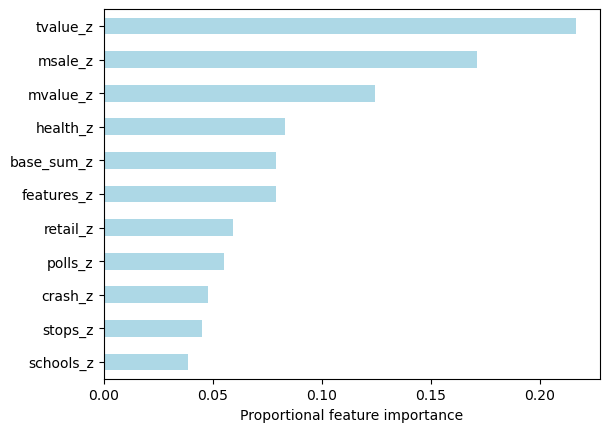

In [14]:
# Graphing feature importances
importances_rf = pd.Series(rf.feature_importances_, index=X.columns).sort_values()
ax = importances_rf.plot(kind="barh", color="lightblue")
ax.set_xlabel("Proportional feature importance")
plt.show()

In [29]:
# Sigmoid function
def sigmoid(x):
    return 1/(1+math.exp(-x))

# Recalculating the scores from task 3 with new weightings
new_scores = 0
for i, col in enumerate(X.columns):
    new_scores += rf.feature_importances_[i]*X[col]
aggs["weighted_score"] = new_scores.apply(sigmoid)

aggs.head()

,sa2_code,retail_z,health_z,schools_z,stops_z,polls_z,base_sum_z,base_score,features_z,crash_z,mvalue_z,msale_z,tvalue_z,new_weighted_score,weighted_score
0,102011028,-0.083562,0.482574,-0.361932,-0.506684,-0.699484,-1.169088,0.237020,-0.180290,-0.987603,-1.055815,-0.948127,-0.811503,0.339895,0.339895
1,102011029,-0.576700,-0.407315,-0.359995,-1.333982,-1.089237,-3.767229,0.022594,-0.803067,-0.211056,-1.055815,-0.948127,-0.811503,0.260375,0.260375
2,102011030,1.489806,0.329748,11.349496,-1.767635,-1.172779,10.228636,0.867512,-1.276808,18.606058,-0.871914,-0.802447,-0.837809,0.828793,0.828793
3,102011031,1.275253,1.266340,0.834700,-1.222070,-0.908423,1.245801,0.776572,-0.952474,0.290687,-1.055815,-0.948127,-0.811503,0.419630,0.419630
4,102011032,0.704316,1.320492,-0.178614,-0.355391,-0.537473,0.953330,0.721784,-0.234403,1.645981,-1.055815,-0.948127,-0.811503,0.441535,0.441535


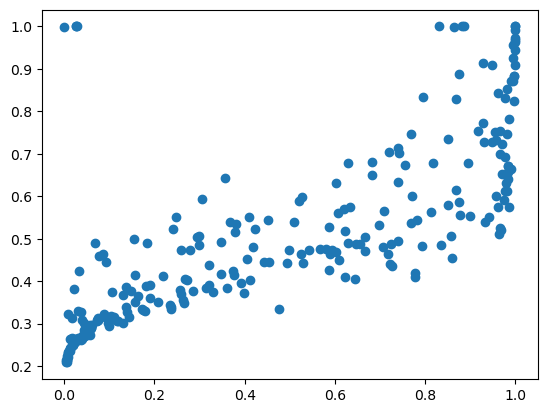

In [30]:
plt.scatter(aggs["base_score"], aggs["weighted_score"])

## Extra commands

In [114]:
# Checks that all tables are in sa2 schema
inspect(db).get_table_names(schema="sa2")

['regions',
 'business',
 'population',
 'stops',
 'polls',
 'catchments',
 'base_scores',
 'features',
 'crashes',
 'values',
 'all_aggs',
 'spatial_ref_sys',
 'income',
 'extended_aggs',
 'extended_scores']